In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import sklearn.model_selection as skm
from functools import partial
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import (PolynomialFeatures,
                                   KBinsDiscretizer,
                                   StandardScaler)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# New imports
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns, sklearn_sm
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

In [2]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [3]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()

In [4]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

In [5]:
def plot_wage_fit(age_df,
                  basis,
                  title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                        bands[:, 0],
                        bands[:, 1]],
                       ['b', 'r--', 'r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    return ax

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

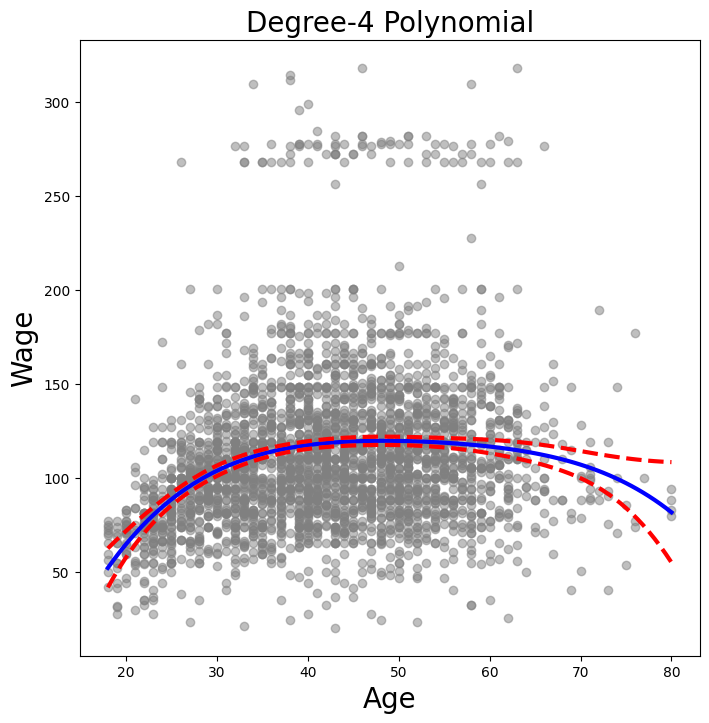

In [6]:
plot_wage_fit(age_df,
              poly_age,
              'Degree-4 Polynomial')

In [7]:
models = [MS([poly('age', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs]).round(3)

df_resid          ssr  df_diff     ss_diff        F  Pr(>F)
0    2998.0  5022216.105      0.0         NaN      NaN     NaN
1    2997.0  4793430.095      1.0  228786.010  143.593   0.000
2    2996.0  4777674.401      1.0   15755.694    9.889   0.002
3    2995.0  4771604.249      1.0    6070.152    3.810   0.051
4    2994.0  4770321.686      1.0    1282.563    0.805   0.370

In [8]:
summarize(M)

coef  std err        t  P>|t|
intercept               111.7036    0.729  153.283  0.000
poly(age, degree=4)[0]  447.0679   39.915   11.201  0.000
poly(age, degree=4)[1] -478.3158   39.915  -11.983  0.000
poly(age, degree=4)[2]  125.5217   39.915    3.145  0.002
poly(age, degree=4)[3]  -77.9112   39.915   -1.952  0.051

In [9]:
models = [MS(['education', poly('age', degree=d)])
          for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs]).round(4)

df_resid           ssr  df_diff      ss_diff         F  Pr(>F)
0    2997.0  3.902335e+06      0.0          NaN       NaN     NaN
1    2996.0  3.759472e+06      1.0  142862.7012  113.9919  0.0000
2    2995.0  3.753546e+06      1.0    5926.2071    4.7286  0.0297

In [10]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)

coef  std err       z  P>|z|
intercept               -4.3012    0.345 -12.457  0.000
poly(age, degree=4)[0]  71.9642   26.133   2.754  0.006
poly(age, degree=4)[1] -85.7729   35.929  -2.387  0.017
poly(age, degree=4)[2]  34.1626   19.697   1.734  0.083
poly(age, degree=4)[3] -47.4008   24.105  -1.966  0.049

Text(0, 0.5, 'P(Wage > 250)')

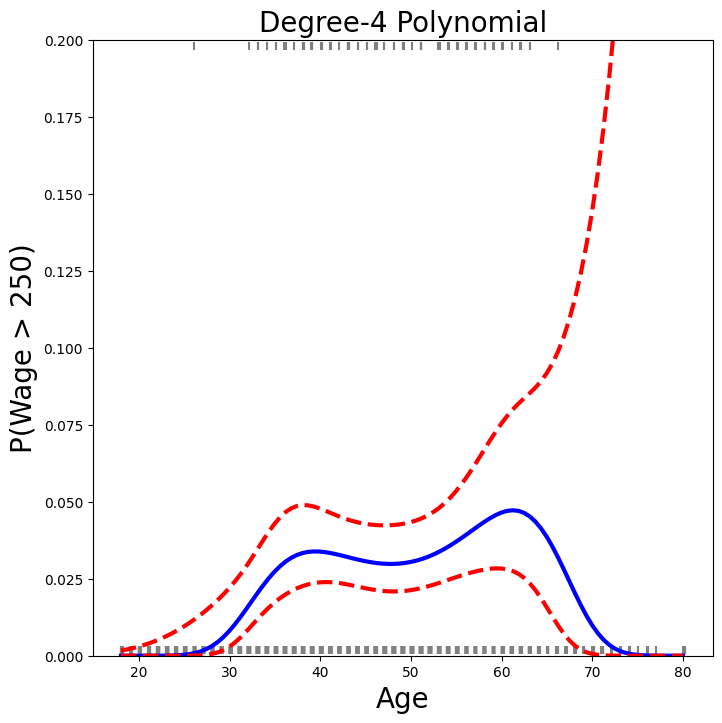

In [11]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
rng = np.random.default_rng()
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean,
                    bands[:, 0],
                    bands[:, 1]],
                   ['b', 'r--', 'r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0, 0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20)

In [12]:
# Step functions

cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

coef  std err       t  P>|t|
(17.999, 33.75]   94.1584    1.478  63.692    0.0
(33.75, 42.0]    116.6608    1.470  79.385    0.0
(42.0, 51.0]     119.1887    1.416  84.147    0.0
(51.0, 80.0]     116.5717    1.559  74.751    0.0

# Splines

In [13]:
bs_ = BSpline(internal_knots=[25, 40, 60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [14]:
bs_age.columns

Index(['BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[0]',
       'BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[1]',
       'BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[2]',
       'BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[3]',
       'BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[4]',
       'BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[5]',
       'BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n        upper_bound=80.0)[6]'],
      dtype='object')

In [15]:
bs_age = MS([bs('age',
                internal_knots=[25, 40, 60],
                name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

coef  std err      t  P>|t|
intercept   60.4937    9.460  6.394  0.000
bs(age)[0]   3.9805   12.538  0.317  0.751
bs(age)[1]  44.6310    9.626  4.636  0.000
bs(age)[2]  62.8388   10.755  5.843  0.000
bs(age)[3]  55.9908   10.706  5.230  0.000
bs(age)[4]  50.6881   14.402  3.520  0.000
bs(age)[5]  16.6061   19.126  0.868  0.385

In [16]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [17]:
# Doing piecewise constant functions as in pd.qcut using B-splines with degree 0

bs_age0 = MS([bs('age',
              df=3,
              degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

coef  std err       t  P>|t|
intercept                   94.1584    1.478  63.687    0.0
bs(age, df=3, degree=0)[0]  22.3490    2.152  10.388    0.0
bs(age, df=3, degree=0)[1]  24.8076    2.044  12.137    0.0
bs(age, df=3, degree=0)[2]  22.7814    2.087  10.917    0.0

In [18]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

coef  std err       t  P>|t|
intercept         60.4752    4.708  12.844  0.000
ns(age, df=5)[0]  61.5267    4.709  13.065  0.000
ns(age, df=5)[1]  55.6912    5.717   9.741  0.000
ns(age, df=5)[2]  46.8184    4.948   9.463  0.000
ns(age, df=5)[3]  83.2036   11.918   6.982  0.000
ns(age, df=5)[4]   6.8770    9.484   0.725  0.468

<Axes: title={'center': 'Natural spline, df=5'}, xlabel='Age', ylabel='Wage'>

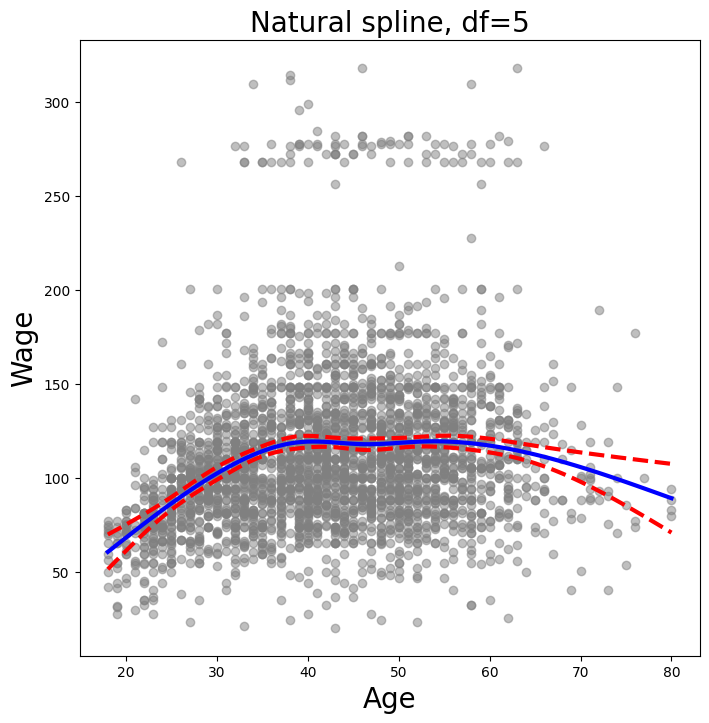

In [19]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5')

<Axes: title={'center': 'B-Spline, knots=[25, 40, 60]'}, xlabel='Age', ylabel='Wage'>

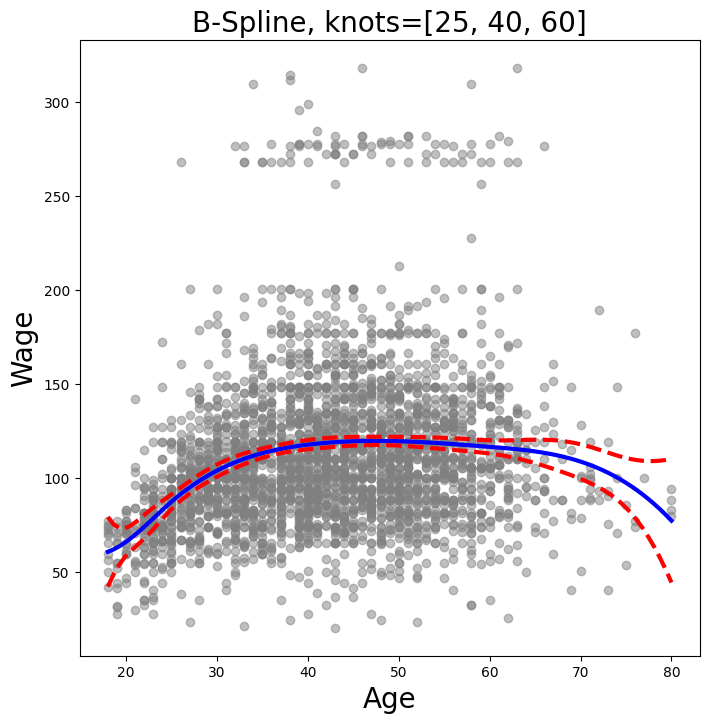

In [20]:
plot_wage_fit(age_df,
              bs_age,
              'B-Spline, knots=[25, 40, 60]')

# Smoothing Splines and GAMs

In [21]:
X_age = np.asarray(age).reshape((-1, 1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

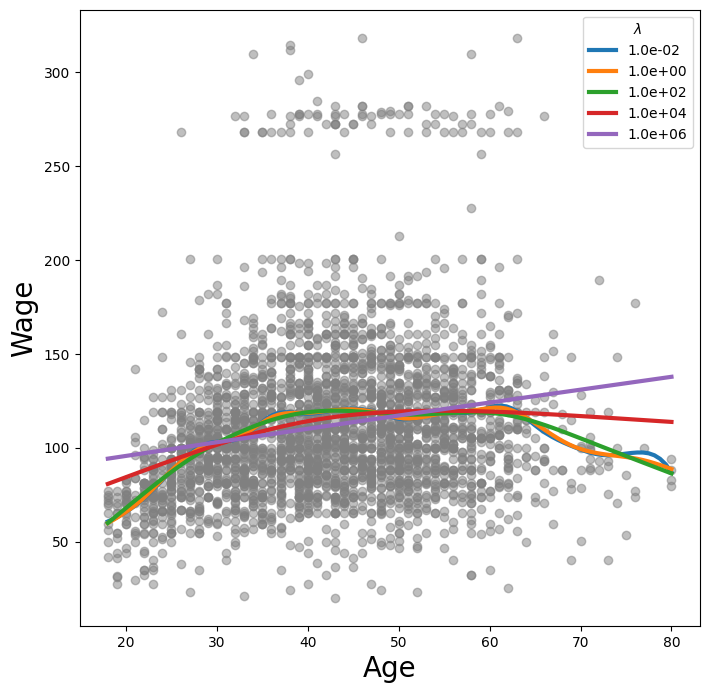

In [22]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='$\lambda$')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


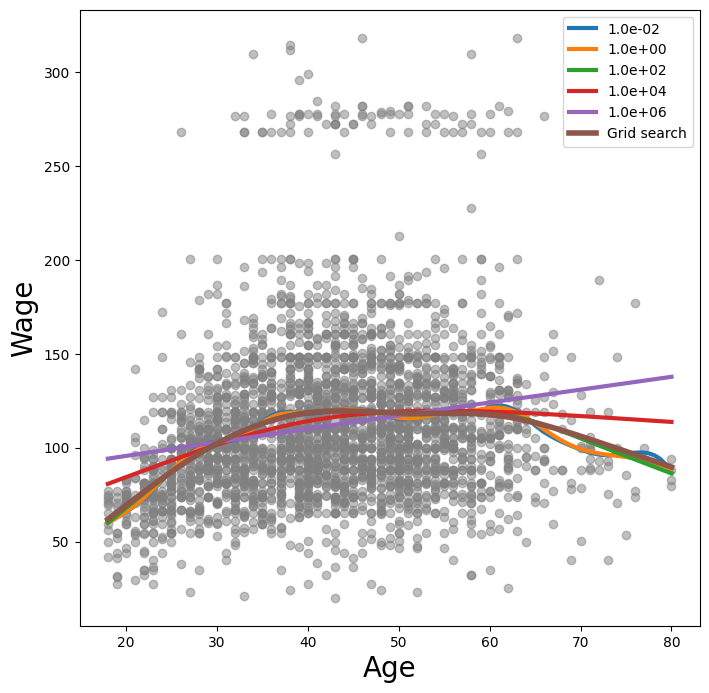

In [23]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

In [24]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100004728

We note here that these
degrees of freedom include the unpenalized intercept and linear term of the
smoothing spline, hence there are at least two degrees of freedom.

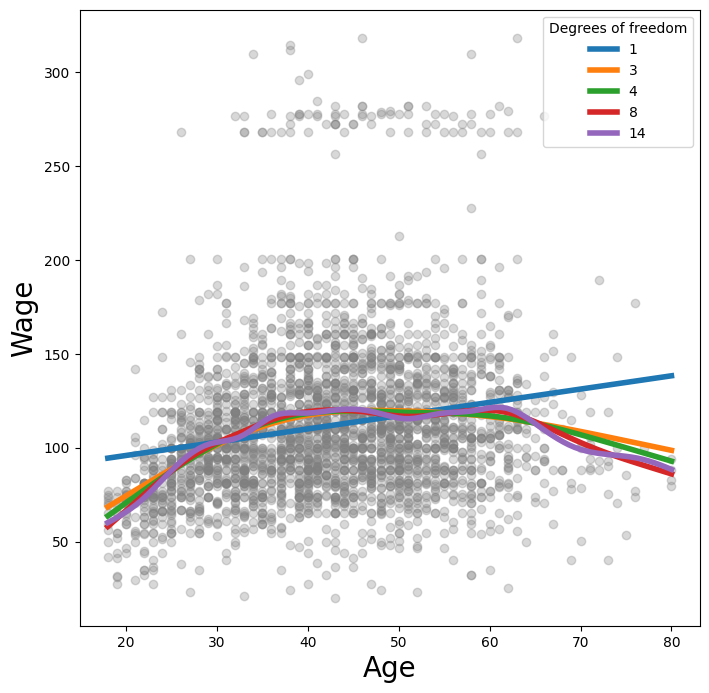

In [25]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1, 3, 4, 8, 14]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='Degrees of freedom')

### Additive models with Several Terms

In [26]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

In [27]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None, :]
X_age_bh[:, :4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

Text(0.5, 1.0, 'Partial dependence of age on wage')

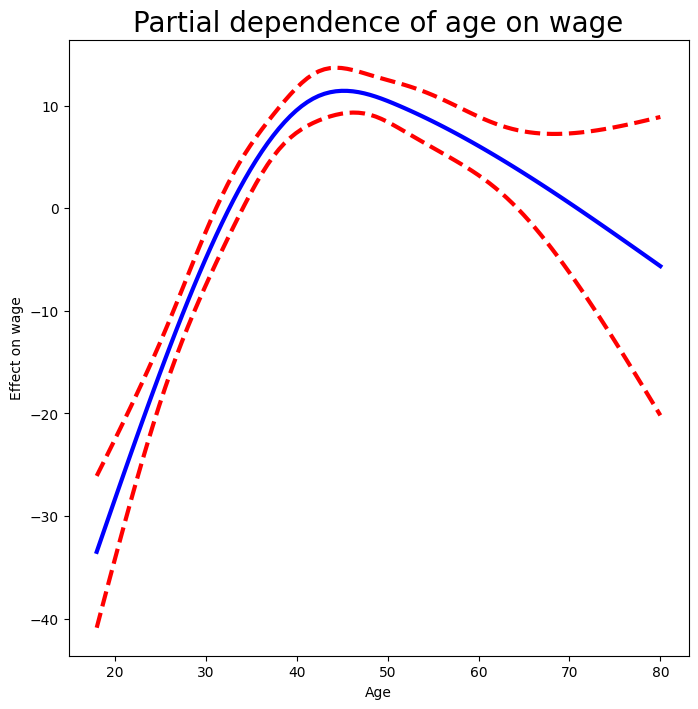

In [28]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:, 0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:, 1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20)

Text(0.5, 1.0, 'Partial dependence of year on wage')

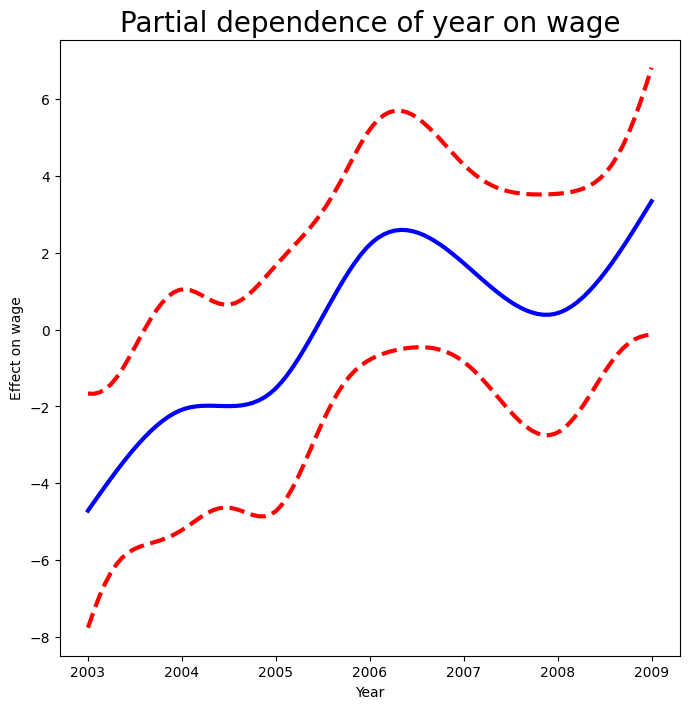

In [29]:
year = Wage['year']
year_grid = np.linspace(year.min(),
                       year.max(),
                       100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None, :]
X_year_bh[:, 4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.plot(year_grid, partial_age, 'b', linewidth=3)
ax.plot(year_grid, bounds_age[:, 0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_age[:, 1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

In [30]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

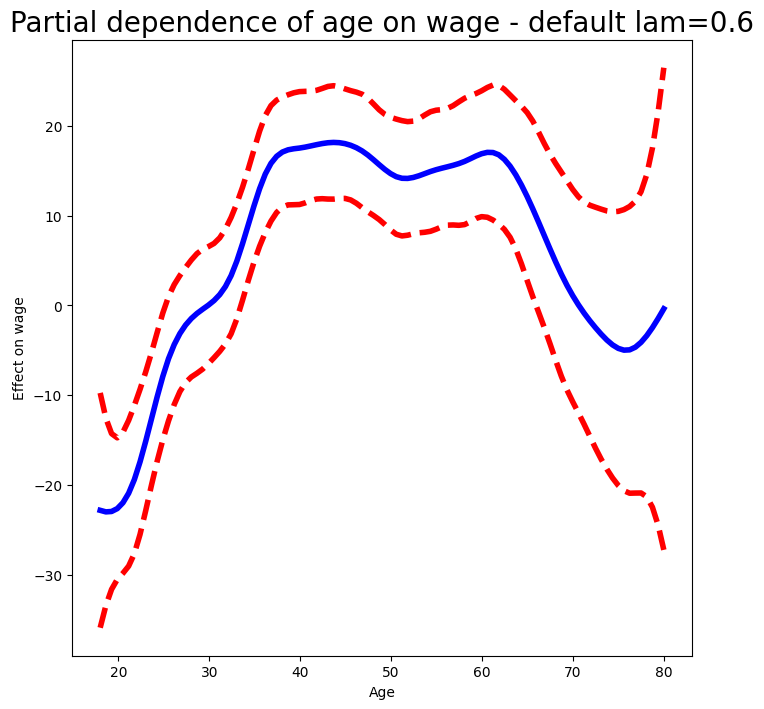

In [31]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20)

In [32]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

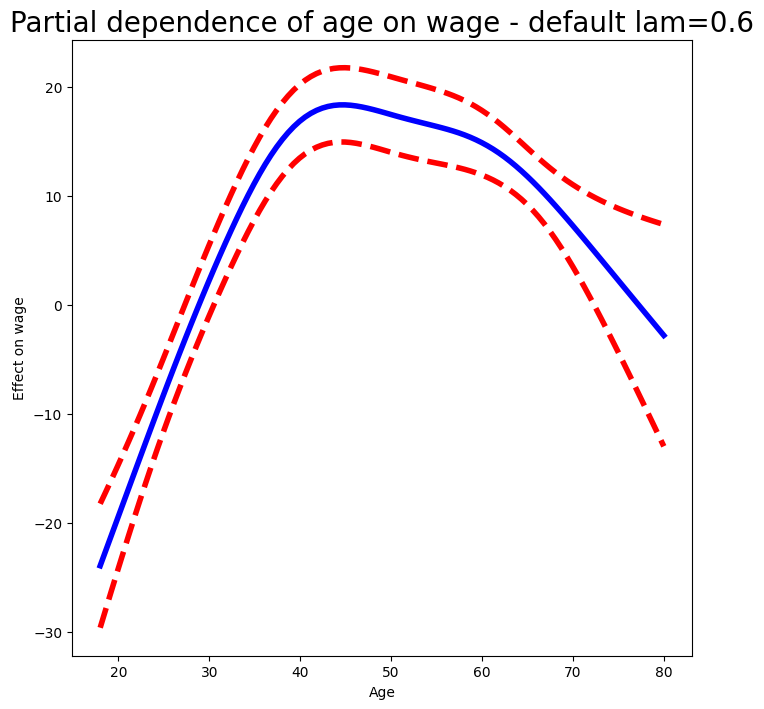

In [33]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

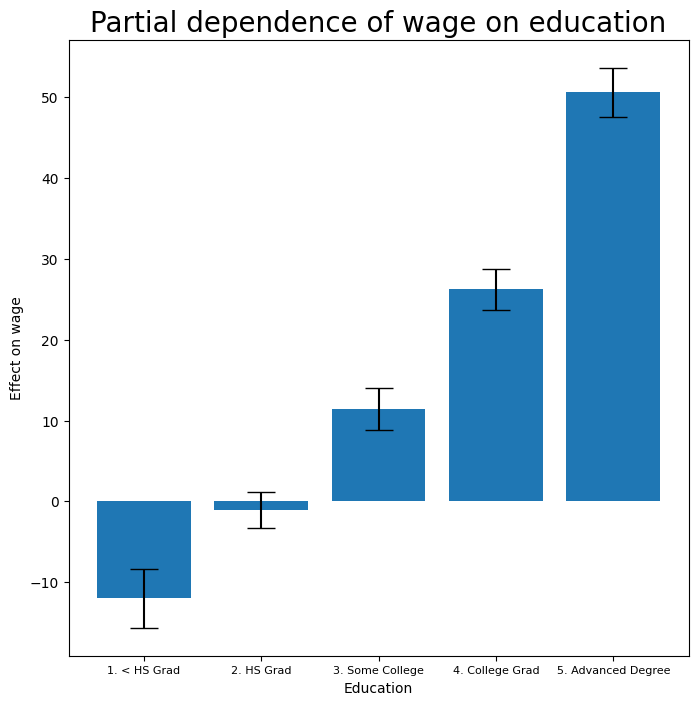

In [34]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_full, 2, ax=ax)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education', fontsize=20)
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

### Anova tests for additive models

In [35]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [36]:
anova_gam(gam_0, gam_linear, gam_full)

deviance           df  deviance_diff   df_diff          F    pvalue
0  3.714362e+06  2991.004005            NaN       NaN        NaN       NaN
1  3.696746e+06  2990.005190   17616.542840  0.998815  14.265131  0.002314
2  3.693143e+06  2987.007254    3602.893655  2.997936   0.972007  0.435579

In [37]:
gam_0 = LinearGAM(year_term + f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

deviance           df  deviance_diff   df_diff           F  \
0  3.975443e+06  2991.000589            NaN       NaN         NaN   
1  3.850247e+06  2990.000704  125196.137317  0.999884  101.270106   
2  3.693143e+06  2987.007254  157103.978302  2.993450   42.447812   

         pvalue  
0           NaN  
1  1.681120e-07  
2  5.669414e-07

In [38]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/tmp/ipykernel_17599/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [39]:
Yhat = gam_full.predict(Xgam)
Yhat

array([ 52.3662492 ,  99.63834745, 111.7723448 , ...,  70.20962308,
        93.60649596, 104.91135937])

In [40]:
gam_logit = LogisticGAM(age_term +
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

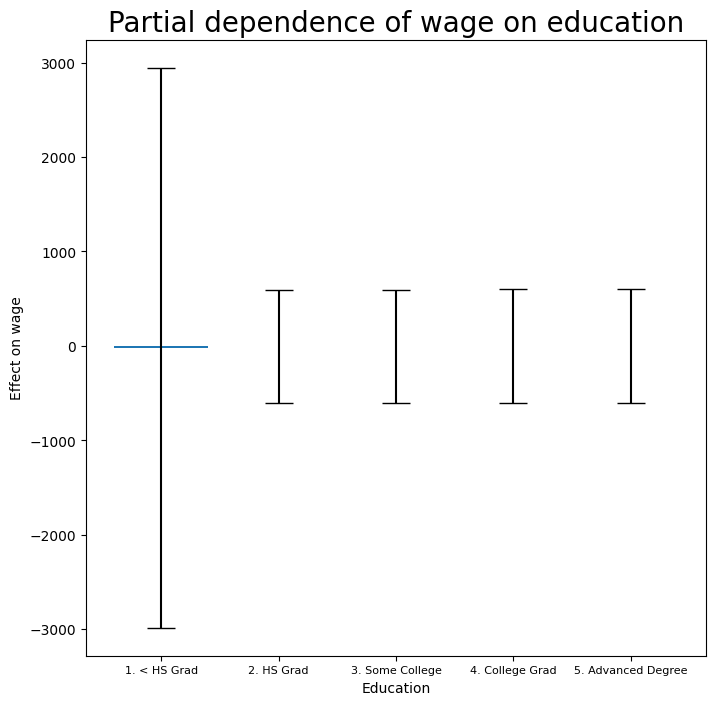

In [41]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_logit, 2, ax=ax)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education', fontsize=20)
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

In [42]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education  1. < HS Grad  2. HS Grad  3. Some College  4. College Grad  \
high_earn                                                               
False               268         966              643              663   
True                  0           5                7               22   

education  5. Advanced Degree  
high_earn                      
False                     381  
True                       45

In [43]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

In [44]:
gam_logit_ = LogisticGAM(age_term + 
                         year_term + 
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

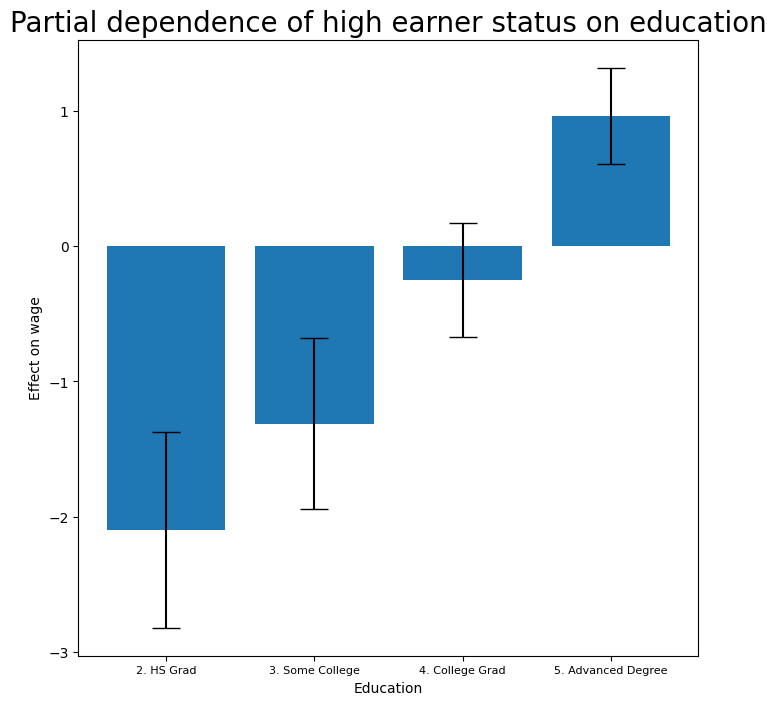

In [45]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_logit_, 2, ax=ax)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20)
ax.set_xticklabels(Wage['education'].cat.categories[1:], fontsize=8)

Text(0.5, 1.0, 'Partial dependence of high earner status on age')

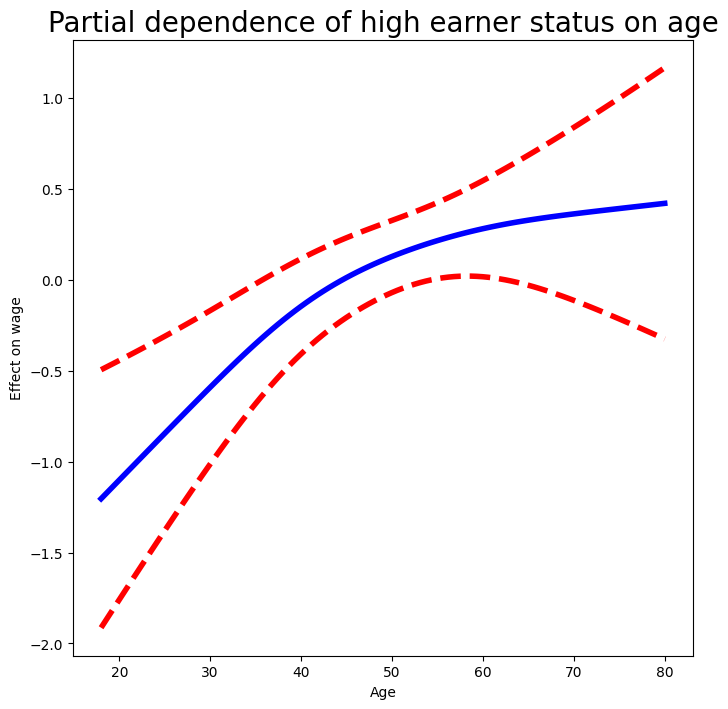

In [46]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_logit_, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age', fontsize=20)

Text(0.5, 1.0, 'Partial dependence of high earner status on year')

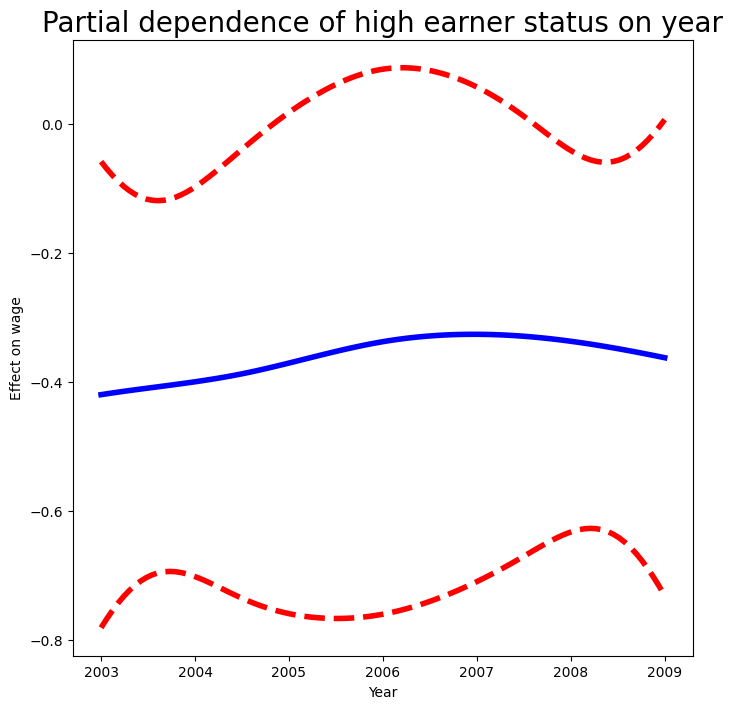

In [47]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
plot_gam(gam_logit_, 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year', fontsize=20)

# Local regression

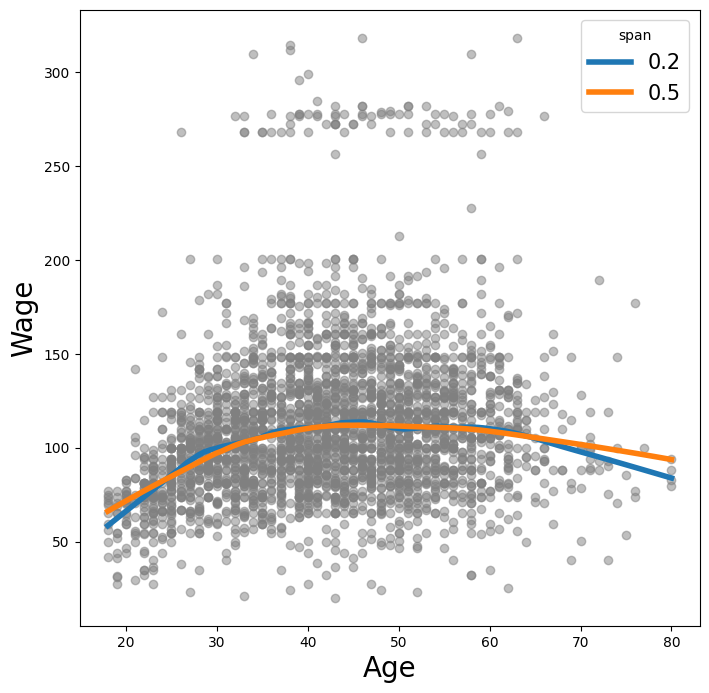

In [48]:
lowess = sm.nonparametric.lowess
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    ax.legend(title='span', fontsize=15)

# Exercises

1. It was mentioned in this chapter that a cubic regression spline with one knot at ξ can be obtained using a basis function of the form x, x^2, x^3, (x-ξ)+^3, where (x-ξ)+^3 = (x-ξ)^3 if x > ξ and equals 0 otherwise. We will now show that a function of the form

   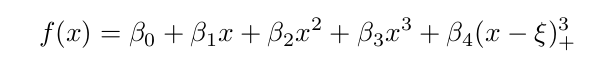

   is indeed a cubic regression spline, regardless of the values of the coefficients B.

   (a) Find a cubic polynomial

   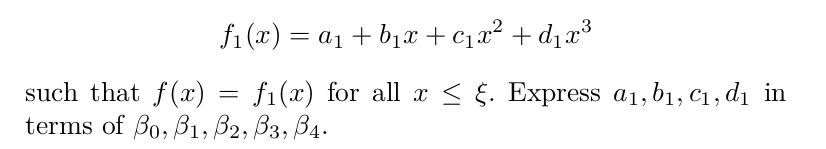

   answer = https://rstudio-pubs-static.s3.amazonaws.com/65563_d6411480e07b4aaaad9b484b66210497.html

   (b) Find a cubic polynomial

   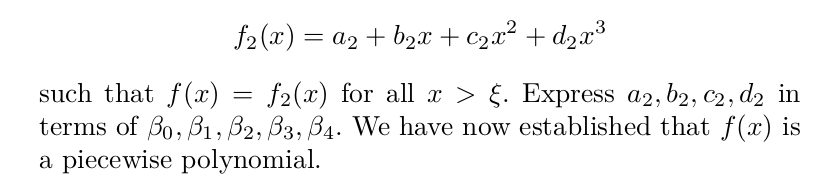

   (c) Show that f1(ξ) = f2(ξ). That is, f(x) is continuous at ξ.
   (did it on paper)

   (d) Show that f'1(ξ) = f'2(ξ). That is, f(x) is continuous at ξ.
   (did it on paper)

   (e) Show that f''1(ξ) = f''2(ξ). That is, f(x) is continuous at ξ.
   (did it on paper)

2. Suppose that a curve g^ is computed to smoothly fit a set of n points using the following formula:

   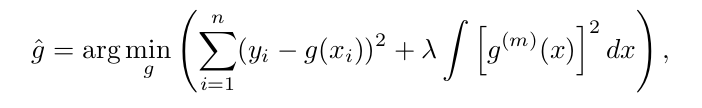

   where g^(m) represents the mth derivative of g (and g^(0) = g). Provide  example sketches of g^ in each of the following scenarios.

   for (a) till (d) g^ is a straight line. for the tuning parameter 0 in the case of (e), the g^ simply interpolates every single point with training error of 0.

   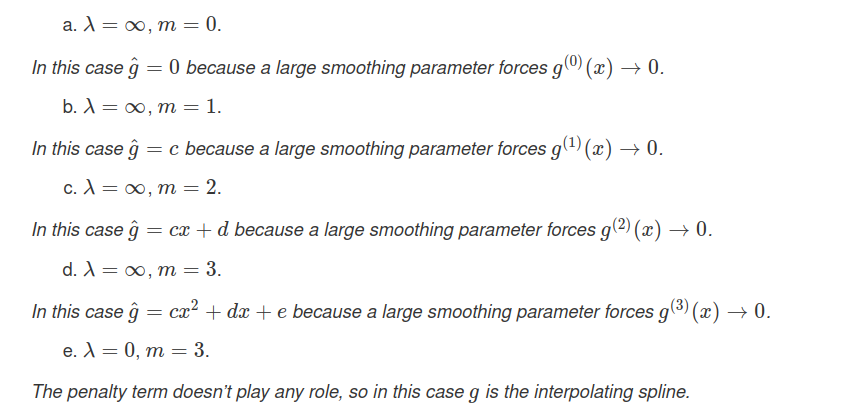

3. Suppose we fit a curve with basis functions
  
   b1(X)=X,

   b2(X)=(X-1)^2*I(X>=1) (Note that I(X ≥ 1) equals 1 for X ≥ 1 and 0 otherwise. We fit the linear regression model:

   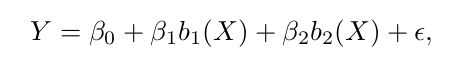

and obtain coefficient estimates ̂B0=1, B1^=1, B2^=-2. Sketch the estimated error curve between X=-2 and X=2. Note the intercepts, slopes and other relevant information.

4. Suppose we fit a curve with basis functions
  
   b1(X) = I(0 ≤ X ≤ 2) − (X − 1)I(1 ≤ X ≤ 2),

   b2 (X) = (X − 3)I(3 ≤ X ≤ 4) + I(4 < X ≤ 5)

   We fit the linear regression model:

   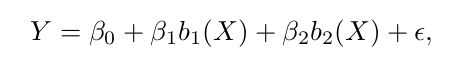

and obtain coefficient estimates ̂B0=1, B1^=1, B2^=3. Sketch the estimated error curve between X=-2 and X=6. Note the intercepts, slopes and other relevant information.

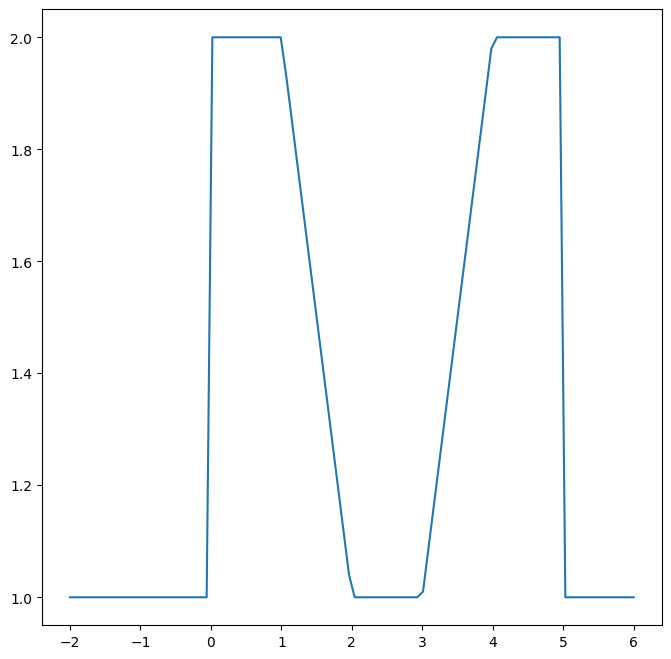

In [49]:
def I(lower_limit, x, upper_limit):
    return np.where((x >= lower_limit) & (x <= upper_limit), 1, 0) 

X = np.linspace(-2, 6, 100)

y = 1 + I(0, X, 2) - (X - 1)*I(1, X, 2) + (X - 3)*I(3, X, 4) + I(4, X, 5)

fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.plot(X, y)

5. Consider two curves, g1^ and g2^ defined by:

   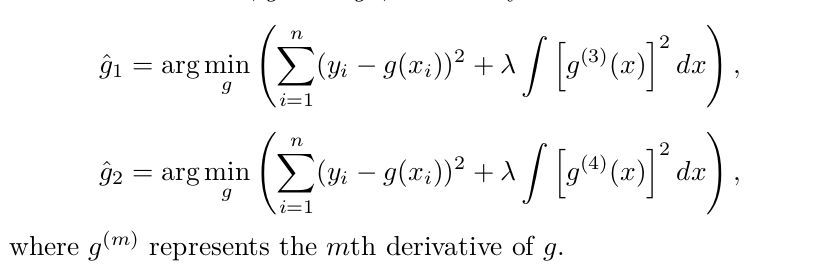

   (a) As lambda -> inf, will g1 or g2 have the smaller training RSS?

    g2 will have a more flexible fit and hence will have lower training RSS.

    g1 will have g^ = b0 + b1x + b2x^2 and g2 will have an additional cubic parameter

    (b) As lambda -> inf, will g1^ or g2^ have the smaller test RSS?

    probably g1 as g2 will overfit the data

    (c) For lambda = 0, will g1^ or g2^ have the smaller training and test RSS?

    they will have the exact same training and test RSS. training rss will be 0 though

6. In this exercise, you will further analyze the Wage data set considered throughout this chapter.

   (a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [50]:
kfold = skm.KFold(n_splits=5, random_state=0, shuffle=True)

X = Wage['age'].to_numpy().reshape(-1, 1)
y = Wage['wage'].to_numpy().reshape(-1, 1)
param_grid = {'polynomial__degree': range(0, 13)}
polynomialTransformation = PolynomialFeatures()
lr = skl.LinearRegression()

pipe_poly = Pipeline([('polynomial', polynomialTransformation),
                      ('regression', lr)])
grid = skm.GridSearchCV(pipe_poly,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=kfold,
                        verbose=True)
grid.fit(X, y)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('regression', LinearRegression())]),
             param_grid={'polynomial__degree': range(0, 13)},
             scoring='neg_mean_squared_error', verbose=True)

In [51]:
grid.best_params_['polynomial__degree']

4

Text(0.5, 0, 'Polynomial Degree')

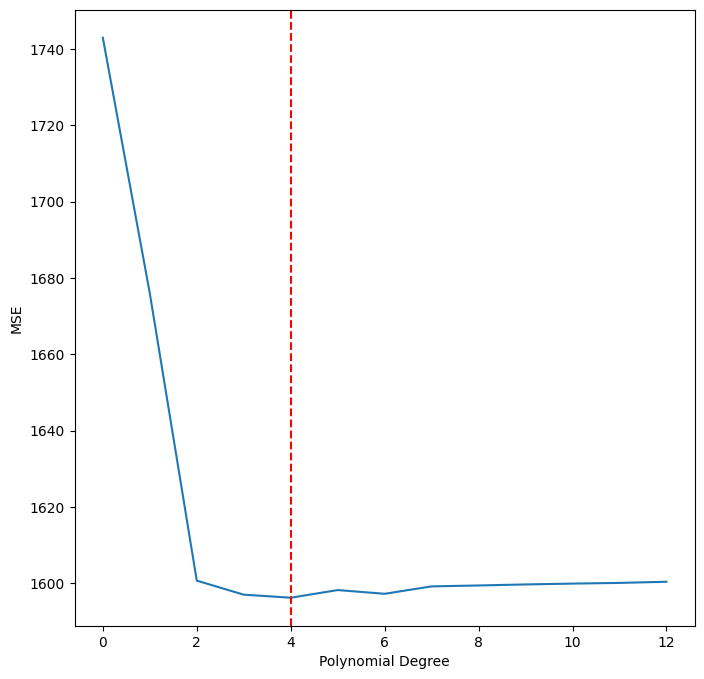

In [52]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()

ax.plot(range(0, 13),
             -grid.cv_results_['mean_test_score'])
ax.axvline((-grid.cv_results_['mean_test_score']).argmin(),
           linestyle='--',
           c='r')
ax.set_ylabel('MSE')
ax.set_xlabel('Polynomial Degree')

<Axes: title={'center': 'Polynomial regression, d=4'}, xlabel='Age', ylabel='Wage'>

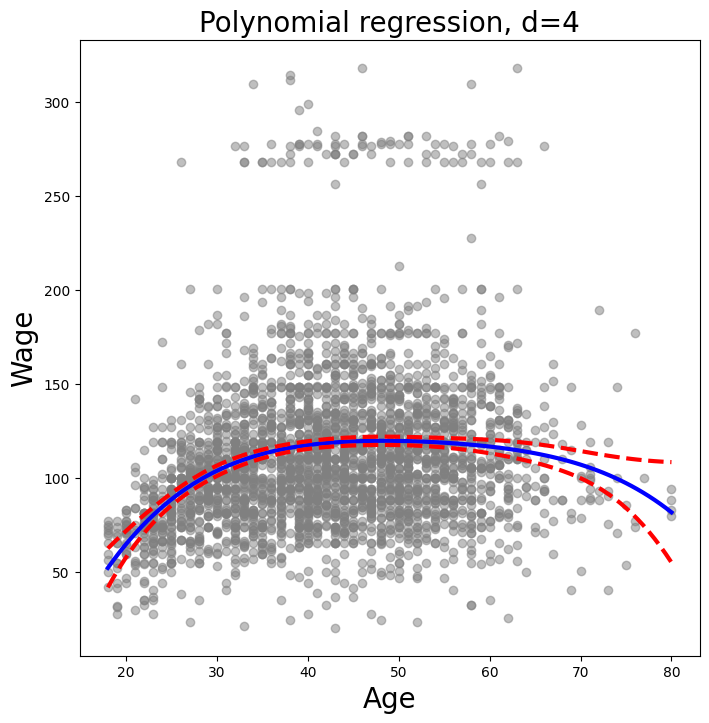

In [53]:
ns_age = MS([poly('age', degree=4)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()

plot_wage_fit(age_df,
              ns_age,
              'Polynomial regression, d=4')

The 4th degree seems to be optimal, just like how the ANOVA shows.

(b) Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [54]:
# Step functions
qcut = KBinsDiscretizer()
param_grid = {'qcut__n_bins': range(2, 21)}
pipe = Pipeline([('qcut', qcut),
                 ('regression', lr)])
grid = skm.GridSearchCV(pipe,
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=kfold,
                    verbose=True)
grid.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('qcut', KBinsDiscretizer()),
                                       ('regression', LinearRegression())]),
             param_grid={'qcut__n_bins': range(2, 21)},
             scoring='neg_mean_squared_error', verbose=True)

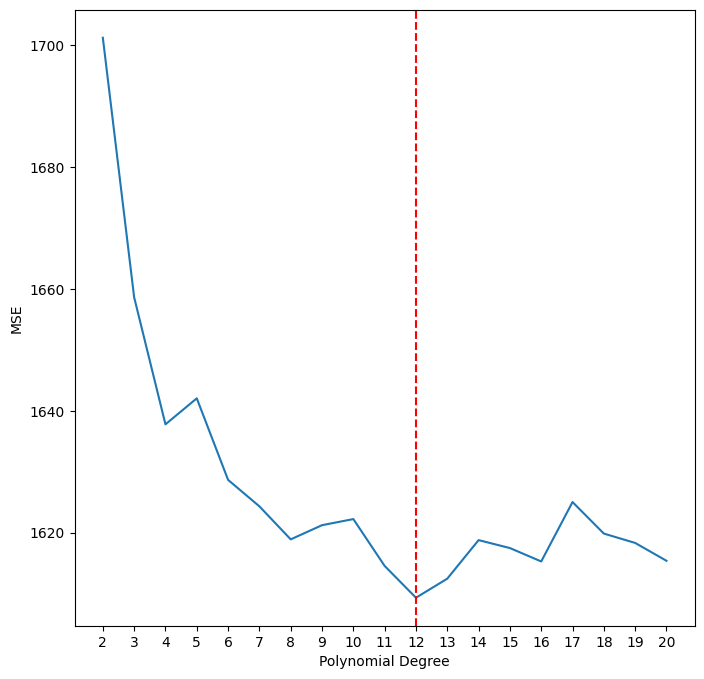

In [55]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()

ax.plot(range(2, 21),
             -grid.cv_results_['mean_test_score'])
ax.axvline((-grid.cv_results_['mean_test_score']).argmin() + 2,
           linestyle='--',
           c='r')
ax.set_ylabel('MSE')
ax.set_xlabel('Polynomial Degree')
ticks = ax.set_xticks(range(2, 21))

In [56]:
# Step functions
cut_age = pd.qcut(age, 12).to_numpy()
cut_age

array([Interval(17.999, 26.0, closed='right'),
       Interval(17.999, 26.0, closed='right'),
       Interval(42.0, 45.0, closed='right'), ...,
       Interval(26.0, 30.0, closed='right'),
       Interval(26.0, 30.0, closed='right'),
       Interval(54.0, 58.0, closed='right')], dtype=object)

In [57]:
model = sm.OLS(y, pd.get_dummies(cut_age)).fit()

In [58]:
preds = model.get_prediction(pd.get_dummies(pd.qcut(age_grid, 12)))
bands = preds.conf_int(alpha=0.05)

Text(0, 0.5, 'Wage')

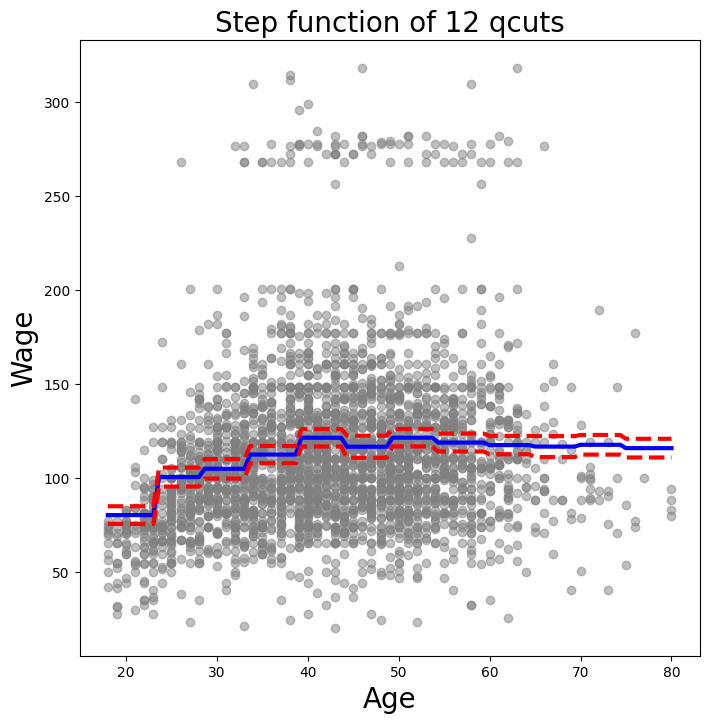

In [59]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(age,
           y,
           facecolor='gray',
           alpha=0.5)
for val, ls in zip([preds.predicted_mean,
                    bands[:, 0],
                    bands[:, 1]],
                   ['b', 'r--', 'r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Step function of 12 qcuts', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)

7. The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predicotrs and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

In [60]:
Wage.head()

year  age            maritl      race        education              region  \
0  2006   18  1. Never Married  1. White     1. < HS Grad  2. Middle Atlantic   
1  2004   24  1. Never Married  1. White  4. College Grad  2. Middle Atlantic   
2  2003   45        2. Married  1. White  3. Some College  2. Middle Atlantic   
3  2003   43        2. Married  3. Asian  4. College Grad  2. Middle Atlantic   
4  2005   50       4. Divorced  1. White       2. HS Grad  2. Middle Atlantic   

         jobclass          health health_ins   logwage        wage  high_earn  
0   1. Industrial       1. <=Good      2. No  4.318063   75.043154      False  
1  2. Information  2. >=Very Good      2. No  4.255273   70.476020      False  
2   1. Industrial       1. <=Good     1. Yes  4.875061  130.982177      False  
3  2. Information  2. >=Very Good     1. Yes  5.041393  154.685293      False  
4  2. Information       1. <=Good     1. Yes  4.318063   75.043154      False

In [61]:
unexplored = ['race', 'maritl', 'jobclass', 
              'health', 'health_ins', 'region']
for feature in unexplored:
    print(feature, Wage[feature].unique())

race ['1. White' '3. Asian' '4. Other' '2. Black']
maritl ['1. Never Married' '2. Married' '4. Divorced' '3. Widowed' '5. Separated']
jobclass ['1. Industrial' '2. Information']
health ['1. <=Good' '2. >=Very Good']
health_ins ['2. No' '1. Yes']
region ['2. Middle Atlantic']


Might aswell just remove region.

In [62]:
Wage = Wage.drop(columns='region')
unexplored = unexplored[:-1]

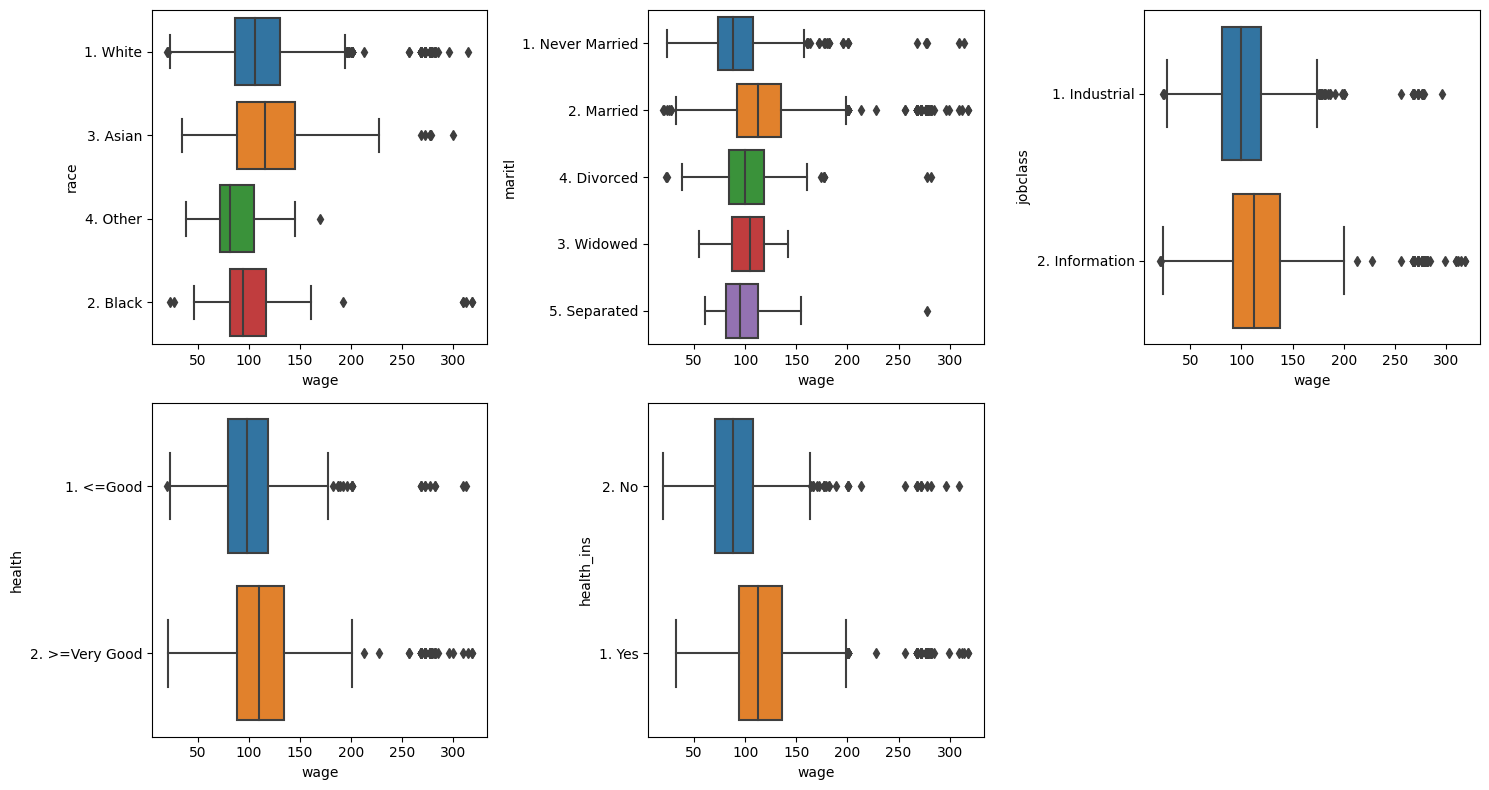

In [63]:
fig = plt.figure(figsize=(15, 8))
for i, feature in enumerate(unexplored):
    ax = fig.add_subplot(2, 3, i+1)
    sns.boxplot(ax=ax,
                data=Wage,
                y=feature,
                x='wage')
fig.tight_layout()

In [64]:
#base model
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
model = gam_full.fit(X=Xgam, y=y)

In [65]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0) +
                     f_gam(3, lam=0))

<Axes: >

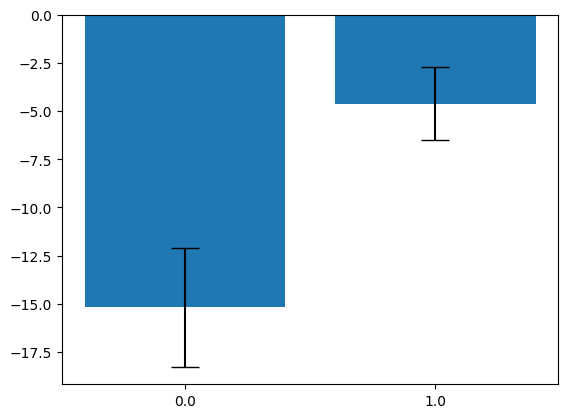

In [66]:
Wage['health'] = Wage['health'].astype("category")
health = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes,
                        Wage['health'].cat.codes])
health = gam_full.fit(X=health, y=y)
plot_gam(health, 3, [0.05, 0.95])

[Text(0, 0, '1. White'),
 Text(1, 0, '2. Black'),
 Text(2, 0, '3. Asian'),
 Text(3, 0, '4. Other')]

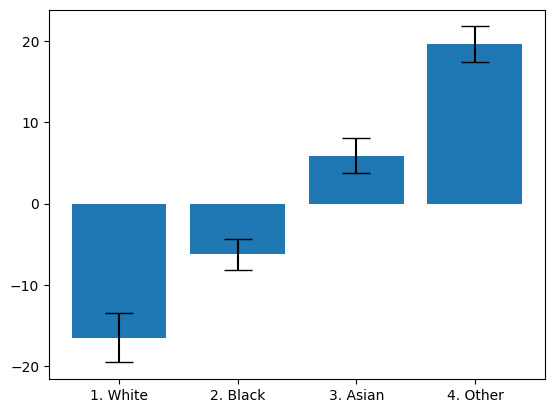

In [67]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0) +
                     f_gam(3, lam=0) + 
                     f_gam(4, lam=0))
Wage['race'] = Wage['race'].astype("category")
race = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes,
                        Wage['health'].cat.codes,
                        Wage['race'].cat.codes])
race = gam_full.fit(X=race, y=y)
ax = plot_gam(race, 4, [0.05, 0.95])
ax.set_xticklabels(Wage['race'].cat.categories)

Text(0, 0.5, 'Effect on wage')

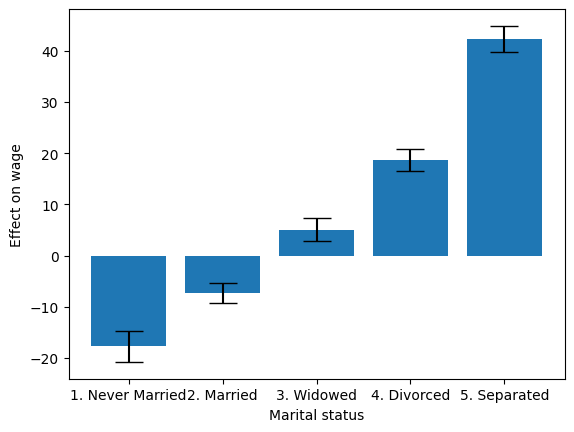

In [68]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0) +
                     f_gam(3, lam=0) + 
                     f_gam(4, lam=0) + 
                     f_gam(5, lam=0))
Wage['maritl'] = Wage['maritl'].astype("category")
maritl = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes,
                        Wage['health'].cat.codes,
                        Wage['race'].cat.codes,
                        Wage['maritl'].cat.codes])
maritl = gam_full.fit(X=maritl, y=y)
ax = plot_gam(maritl, 5, [0.05, 0.95])
ax.set_xticklabels(Wage['maritl'].cat.categories)
ax.set_xlabel('Marital status')
ax.set_ylabel('Effect on wage')

In [69]:
anova_gam(model, health, maritl)

deviance           df  deviance_diff   df_diff          F        pvalue
0  3.680640e+06  2976.214249            NaN       NaN        NaN           NaN
1  3.640681e+06  2975.214877   39959.687746  0.999372  33.456968  2.087725e-06
2  3.547357e+06  2968.221572   93324.040710  6.993305  11.166126  4.865823e-07

8. Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [70]:
Auto = load_data('Auto')
Auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [71]:
Auto_grid = (Auto
             .drop(columns='name')
             .apply(lambda x: np.linspace(x.min(), x.max(), 1000), axis='rows'))

In [72]:
def plot_wage_fit(M,
                  pred_obj,
                  Xnew,
                  title,
                  ax):
    bands = pred_obj.conf_int(alpha=0.05)
    for val, ls in zip([pred_obj.predicted_mean,
                        bands[:, 0],
                        bands[:, 1]],
                       ['b', 'r--', 'r--']):
        ax.plot(Xnew, val, ls, linewidth=3,
               label=(title if ls == 'b' else None))

### Polynomial regression

Let's do polynomial and natural spline regression to predict mpg using horsepower.

In [73]:
kfold = skm.KFold(n_splits=10, random_state=0, shuffle=True)

X = Auto['horsepower'].to_numpy().reshape(-1, 1)
y = Auto['mpg'].to_numpy().reshape(-1, 1)
param_grid = {'polynomial__degree': range(0, 13)}
polynomialTransformation = PolynomialFeatures()
lr = skl.LinearRegression()

pipe_poly = Pipeline([('polynomial', polynomialTransformation),
                      ('regression', lr)])
grid = skm.GridSearchCV(pipe_poly,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=kfold,
                        verbose=True)
grid.fit(X, y)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('regression', LinearRegression())]),
             param_grid={'polynomial__degree': range(0, 13)},
             scoring='neg_mean_squared_error', verbose=True)

In [74]:
print(grid.cv_results_['mean_test_score'])
best_param = 2

[-61.06506582 -24.20766449 -19.18533142 -19.27626666 -19.47848402
 -19.13720002 -19.04638531 -19.25364411 -19.37917208 -19.24897812
 -18.93139372 -18.90579907 -24.38393375]


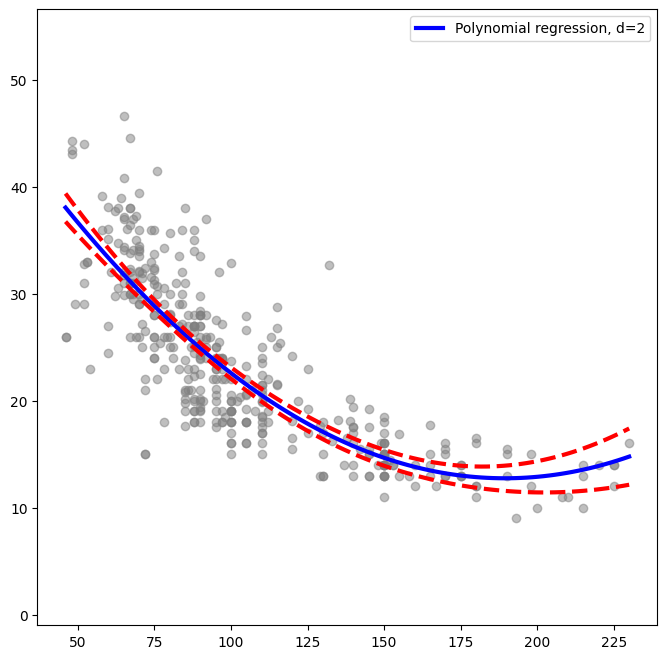

In [75]:
X_poly = PolynomialFeatures(degree=best_param).fit_transform(X)
Xnew = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
Xnew_poly = PolynomialFeatures(degree=best_param).fit_transform(Xnew)
model_poly = sm.OLS(y, X_poly).fit()
preds = model_poly.get_prediction(Xnew_poly)

fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(X,
           y,
           facecolor='gray',
           alpha=0.5)

plot_wage_fit(model_poly, preds, Xnew, f'Polynomial regression, d={best_param}', ax)
ax.set_ylim([y.min()-10, y.max()+10])
ax.legend()

### Natural spline

In [76]:
pipe = Pipeline([('ns', NaturalSpline()),
                 ('lr', skl.LinearRegression())])
param_grid = {'ns__df': range(3, 21)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=kfold)
grid.fit(X, y)
grid.best_params_

{'ns__df': 10}

Looks like 10 degrees of freedom for the natural spline transformation of horsepower has the best MSE.

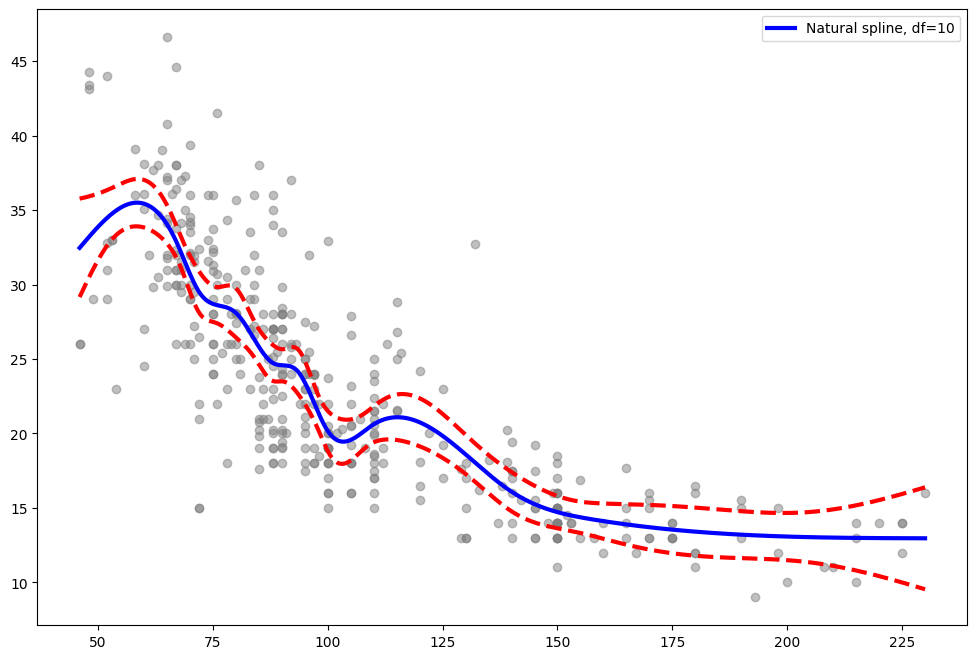

In [77]:
design = MS([ns('horsepower', df=10)]).fit(Auto)
fig = plt.figure(figsize=(12, 8)); ax = fig.add_subplot()
ax.scatter(X,
           y,
           facecolor='gray',
           alpha=0.5)

X_ns = design.transform(Auto)
model_poly = sm.OLS(y, X_ns).fit()
preds = model_poly.get_prediction(design.transform(Auto_grid))

plot_wage_fit(model_poly, preds, Auto_grid['horsepower'], f'Natural spline, df=10', ax)
ax.legend()

### Smoothing splines

In [78]:
gam = LinearGAM(s_gam(0))
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [79]:
lams = np.logspace(-10, 10, 1000)
gam_opt = gam.gridsearch(X, y, lam=lams)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


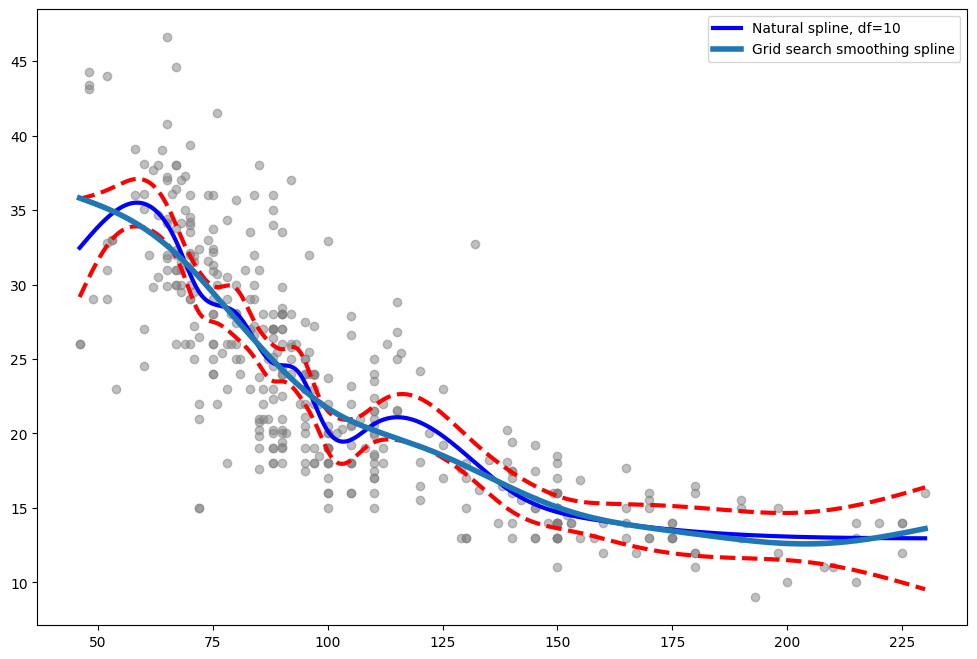

In [80]:
ax.plot(Auto_grid['horsepower'],
        gam_opt.predict(Auto_grid['horsepower']),
        label='Grid search smoothing spline',
        linewidth=4)
ax.legend()
fig

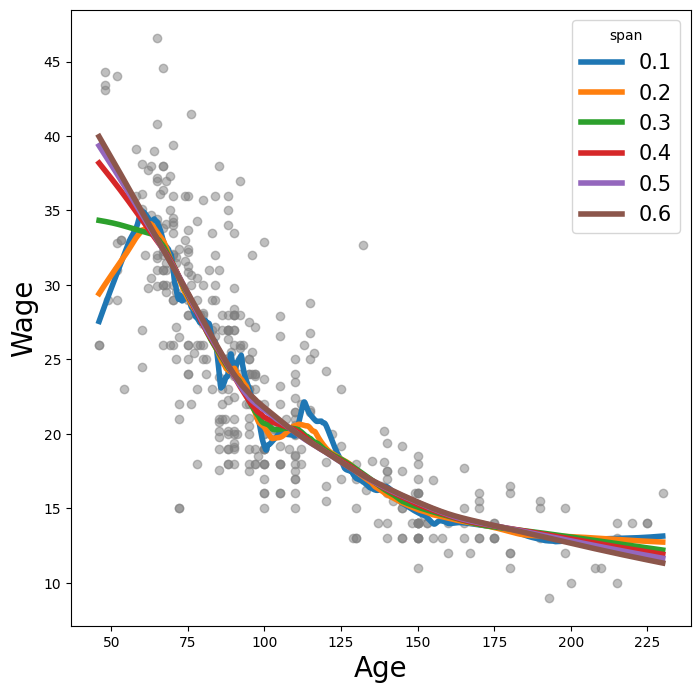

In [81]:
lowess = sm.nonparametric.lowess
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(X, y, facecolor='gray', alpha=0.5)
for span in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    fitted = lowess(y[:, 0],
                    X[:, 0],
                    frac=span,
                    xvals=Auto_grid['horsepower'])
    ax.plot(Auto_grid['horsepower'],
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    ax.legend(title='span', fontsize=15)

9. This question uses the variable dis (the weighted mean of distances to five Boston employment centers) and nox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat dis as the predictor and nox as the response.

In [82]:
Boston = load_data('Boston')
X = Boston['dis']
y = Boston['nox']
Boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

   lstat  medv  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4   5.33  36.2

In [83]:
Boston_grid = (Boston
               .apply(lambda x: np.linspace(x.min(), x.max(), 1000), axis='rows'))

In [84]:
models = [MS([poly('dis', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Boston) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs]).round(3)

df_resid    ssr  df_diff  ss_diff        F  Pr(>F)
0     504.0  2.769      0.0      NaN      NaN     NaN
1     503.0  2.035      1.0    0.733  191.433   0.000
2     502.0  1.934      1.0    0.101   26.407   0.000
3     501.0  1.933      1.0    0.001    0.294   0.588
4     500.0  1.915      1.0    0.018    4.618   0.032

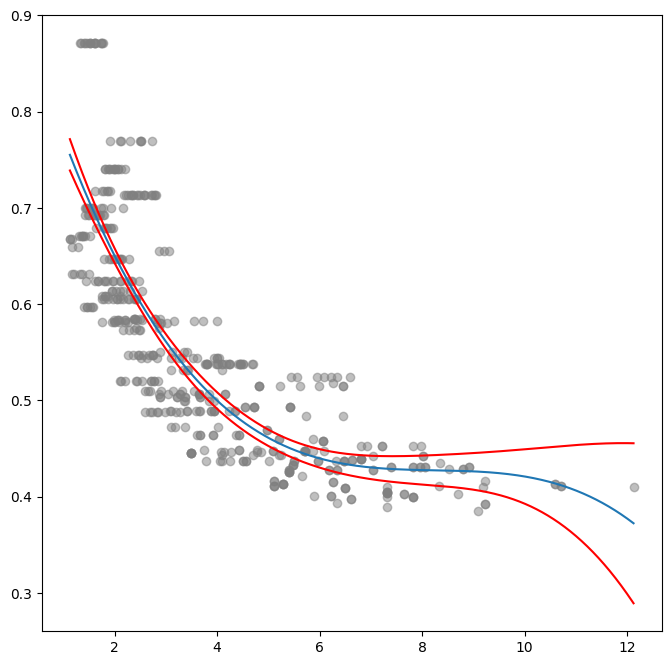

In [85]:
design = MS([poly('dis', degree=3)]).fit(Boston)
model = sm.OLS(y, design.transform(Boston)).fit()
preds = model.get_prediction(design.transform(Boston_grid))
conf_int_vals = preds.conf_int()

fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(X, y, c='gray', alpha=0.5)
ax.plot(Boston_grid['dis'], preds.predicted_mean)
ax.plot(Boston_grid['dis'], conf_int_vals[:, 0], c='r')
ax.plot(Boston_grid['dis'], conf_int_vals[:, 1], c='r')

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          2.71e-136
Time:                        10:06:06   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0.5547      0.003    201.021      0.000       0.549       0.560
poly(dis, degree=3)[0]    -2.0031      0.062    -32.271      0.000      -2.125      -1.881
poly(dis, degree=3)[1]     0.8563      0.062     13.796      0.000       0.734       0.978
poly(dis, degree=3)[2]    -0.3180      0.062     -5.124      0.000      -0.440      -0.196
==============================================================================
Omnibus:                       64.176   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.386
Skew:                           0.917   Prob(JB):                     1.06e-19
Kurtosis:                       3.886   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10) and report the associated residual sum of squares.

In [87]:
models = [MS([poly('dis', degree=d)])
          for d in range(1, 11)]
Xs = [model.fit_transform(Boston) for model in models]
models_for_rss = np.array([*[sm.OLS(y, X_).fit().get_prediction().predicted_mean
                           for X_ in Xs]])

In [88]:
models = [MS([poly('dis', degree=d)])
          for d in range(1, 11)]
models_for_plot = np.array([*[sm.OLS(y, X_).fit().get_prediction(model.fit_transform(Boston_grid)).predicted_mean
                           for model, X_ in zip(models, Xs)]])

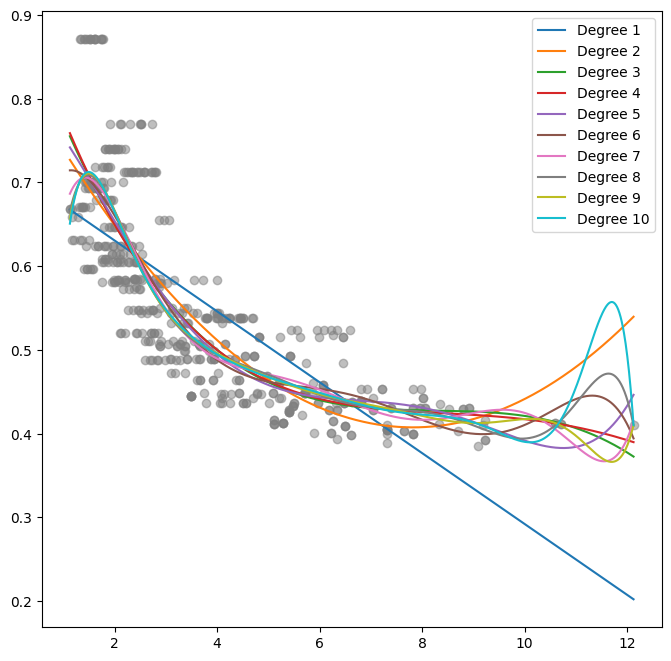

In [89]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(X, y, c='gray', alpha=0.5)
for d in range(1, 11):
    design = MS([poly('dis', degree=d)]).fit(Boston)
    model = sm.OLS(y, design.transform(Boston)).fit()
    preds = model.get_prediction(design.transform(Boston_grid))
    conf_int_vals = preds.conf_int()
    ax.plot(Boston_grid['dis'], preds.predicted_mean, label=f'Degree {d}')
ax.legend()

Text(0, 0.5, 'RSS')

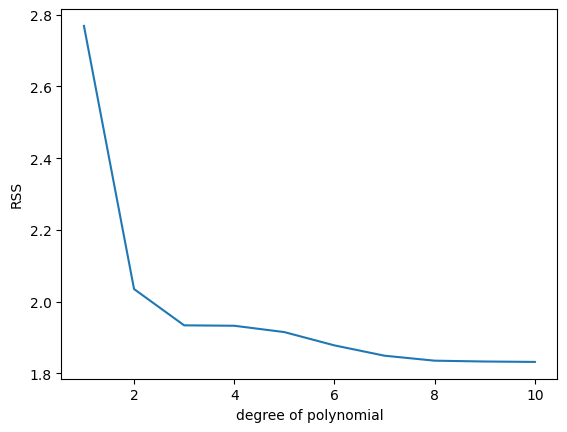

In [90]:
RSS = np.power(y.values - models_for_rss, 2).sum(1)
fig = plt.figure(); ax = fig.add_subplot()
ax.plot(range(1, 11), RSS)
ax.set_xlabel('degree of polynomial')
ax.set_ylabel('RSS')

(c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

In [91]:
param_grid = {'polynomial__degree': range(0, 11)}
polynomialTransformation = PolynomialFeatures()
lr = skl.LinearRegression()

pipe_poly = Pipeline([('polynomial', polynomialTransformation),
                      ('regression', lr)])
grid = skm.GridSearchCV(pipe_poly,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=kfold,
                        verbose=True)
grid.fit(X.to_numpy().reshape(-1, 1),
         y.to_numpy().reshape(-1, 1))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('regression', LinearRegression())]),
             param_grid={'polynomial__degree': range(0, 11)},
             scoring='neg_mean_squared_error', verbose=True)

In [92]:
grid.best_params_

{'polynomial__degree': 3}

In [93]:
grid.cv_results_['mean_test_score']

array([-0.01347742, -0.00551987, -0.00406038, -0.0038537 , -0.00386949,
       -0.00408708, -0.00525387, -0.00877212, -0.00580595, -0.01640191,
       -0.0084756 ])

Text(0, 0.5, 'MSE')

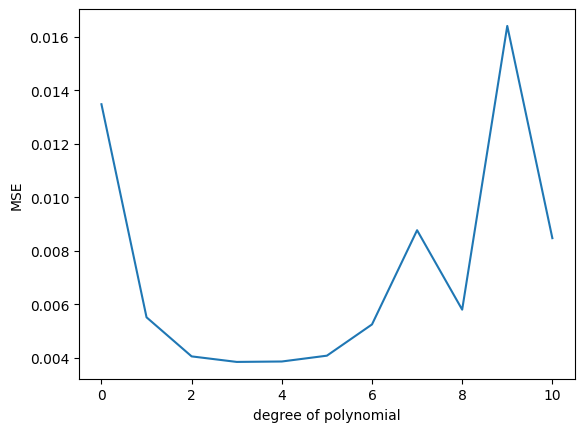

In [94]:
fig = plt.figure(); ax = fig.add_subplot()
ax.plot(range(0, 11), -grid.cv_results_['mean_test_score'])
ax.set_xlabel('degree of polynomial')
ax.set_ylabel('MSE')

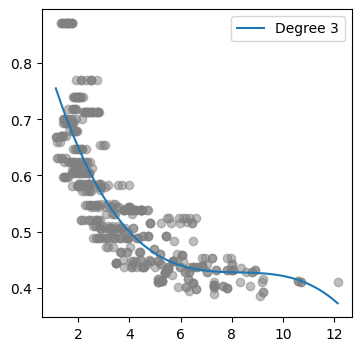

In [95]:
fig = plt.figure(figsize=(4, 4)); ax = fig.add_subplot()
ax.scatter(X, y, c='gray', alpha=0.5)
design = MS([poly('dis', degree=3)]).fit(Boston)
model = sm.OLS(y, design.transform(Boston)).fit()
preds = model.get_prediction(design.transform(Boston_grid))
conf_int_vals = preds.conf_int()
ax.plot(Boston_grid['dis'], preds.predicted_mean, label=f'Degree 3')
ax.legend()

(d) Use the bs() function from the ISLP.models module to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

In [96]:
design = MS([bs('dis', df=4)]).fit(Boston)
model = sm.OLS(y, design.transform(Boston)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nox   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     316.5
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          1.39e-135
Time:                        10:06:07   Log-Likelihood:                 691.93
No. Observations:                 506   AIC:                            -1374.
Df Residuals:                     501   BIC:                            -1353.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.7345      0.015     50.306      0.000       0.706       0.763
bs(dis, df=4)[0]    -0.0581      0.022     -2.658      0.008      -0.101      -0.015
bs(dis, df=4)[1]    -0.4636      0.024    -19.596      0.000      -0.510      -0.417
bs(dis, df=4)[2]    -0.1998      0.043     -4.634      0.000      -0.284      -0.115
bs(dis, df=4)[3]    -0.3888      0.046     -8.544      0.000      -0.478      -0.299
==============================================================================
Omnibus:                       65.894   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.426
Skew:                           0.933   Prob(JB):                     2.31e-20
Kurtosis:                       3.898   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

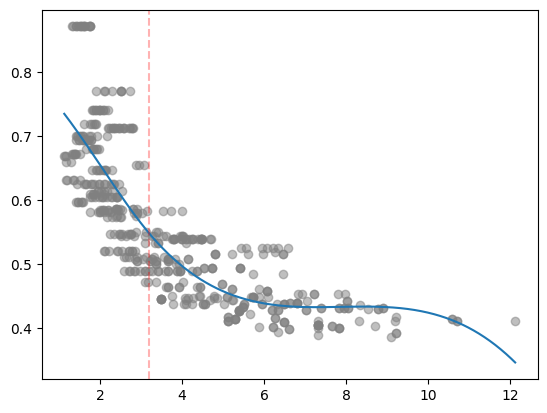

In [97]:
fig = plt.figure(); ax = fig.add_subplot()
ax.scatter(X, y, c='gray', alpha=0.5)
ax.plot(Boston_grid['dis'],
        model.predict(design.transform(Boston_grid)))
ax.axvline(BSpline(df=4).fit(X).internal_knots_, ls='--', alpha=0.3, c='r')

(e) Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

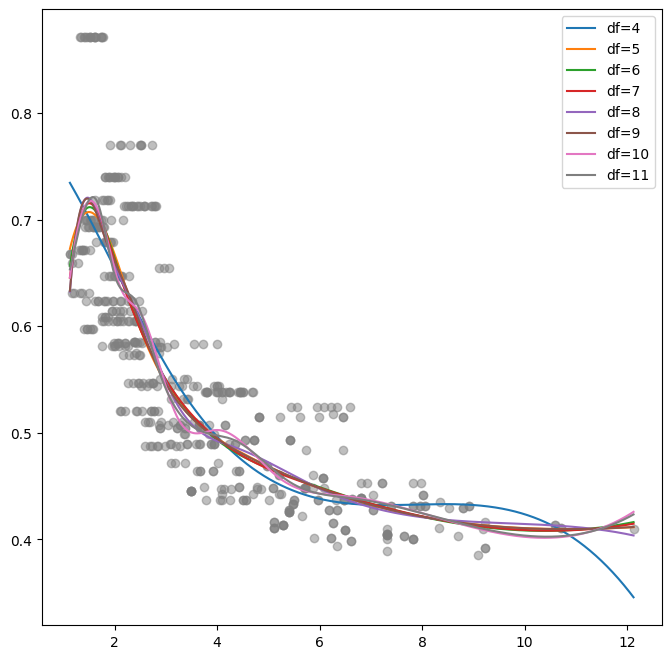

In [98]:
fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot()
ax.scatter(X, y, c='gray', alpha=0.5)
rss = []
for df in range(4, 12):
    design = MS([bs('dis', df=df)]).fit(Boston)
    model = sm.OLS(y, design.transform(Boston)).fit()
    ax.plot(Boston_grid['dis'],
            model.predict(design.transform(Boston_grid)),
            label=f'df={df}')
    rss.append(np.power(y.values - model.get_prediction().predicted_mean, 2).sum())
ax.legend()

Text(0, 0.5, 'RSS')

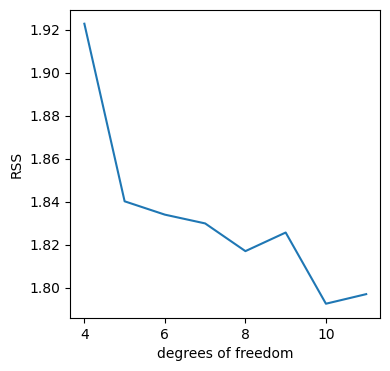

In [99]:
fig = plt.figure(figsize=(4, 4)); ax = fig.add_subplot()
ax.plot(range(4, 12), rss)
ax.set_xlabel('degrees of freedom')
ax.set_ylabel('RSS')

(f) Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

In [100]:
pipe = Pipeline([('bspline', BSpline()),
                 ('lr', skl.LinearRegression())])
grid = skm.GridSearchCV(pipe,
                        scoring='neg_mean_squared_error',
                        cv=kfold,
                        param_grid={'bspline__df': range(4, 30)})
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('bspline', BSpline()),
                                       ('lr', LinearRegression())]),
             param_grid={'bspline__df': range(4, 30)},
             scoring='neg_mean_squared_error')

In [101]:
grid.best_params_

{'bspline__df': 10}

Text(0.5, 0, 'degrees of freedom')

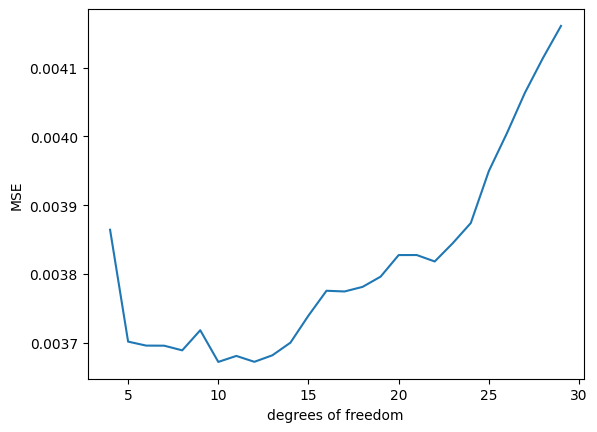

In [102]:
fig = plt.figure(); ax = fig.add_subplot()
ax.plot(range(4, 30),
        -grid.cv_results_['mean_test_score'])
ax.set_ylabel('MSE')
ax.set_xlabel('degrees of freedom')

10. This question relates to the College data set.

    (a) Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [103]:
College = load_data('College')
College['Private'] = np.where(College['Private'] == 'Yes', 1, 0)
y = College.Outstate
X = College.drop(columns='Outstate')
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, y, test_size=0.2, random_state=5)
College.head()

Private  Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0        1  1660    1232     721         23         52         2885   
1        1  2186    1924     512         16         29         2683   
2        1  1428    1097     336         22         50         1036   
3        1   417     349     137         60         89          510   
4        1   193     146      55         16         44          249   

   P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
0          537      7440        3300    450      2200   70        78   
1         1227     12280        6450    750      1500   29        30   
2           99     11250        3750    400      1165   53        66   
3           63     12960        5450    450       875   92        97   
4          869      7560        4120    800      1500   76        72   

   S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0       18.1           12    7041         60  
1       12.2           16   10527         56  
2       12.9           30    8735         54  
3        7.7           37   19016         59  
4       11.9            2   10922         15

Let's try the sklearn.feature_selection module!

In [104]:
def Cp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -((1/n) * (RSS + 2*sigma2*p))

sigma2 = sm.OLS(Y_train, X_train).fit().scale
cp_score = partial(Cp, sigma2)

In [105]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lr', skl.LinearRegression())])
model_selection = SequentialFeatureSelector(pipe,
                                            scoring=cp_score,
                                            direction='forward',
                                            cv=kfold,
                                            n_features_to_select='auto')
model_selection.fit(X_train, Y_train)

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                          estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('lr',
                                                     LinearRegression())]),
                          n_features_to_select='auto',
                          scoring=functools.partial(<function Cp at 0x7f66382cb920>, 4142560.217489916))

In [106]:
print('Features that were found by forward selection:', X.columns[model_selection.support_].values)
print('Features that were excluded by forward selection:', X.columns[~model_selection.support_].values)

Features that were found by forward selection: ['Private' 'Room.Board' 'Personal' 'Terminal' 'S.F.Ratio' 'perc.alumni'
 'Expend' 'Grad.Rate']
Features that were excluded by forward selection: ['Apps' 'Accept' 'Enroll' 'Top10perc' 'Top25perc' 'F.Undergrad'
 'P.Undergrad' 'Books' 'PhD']


(b) Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

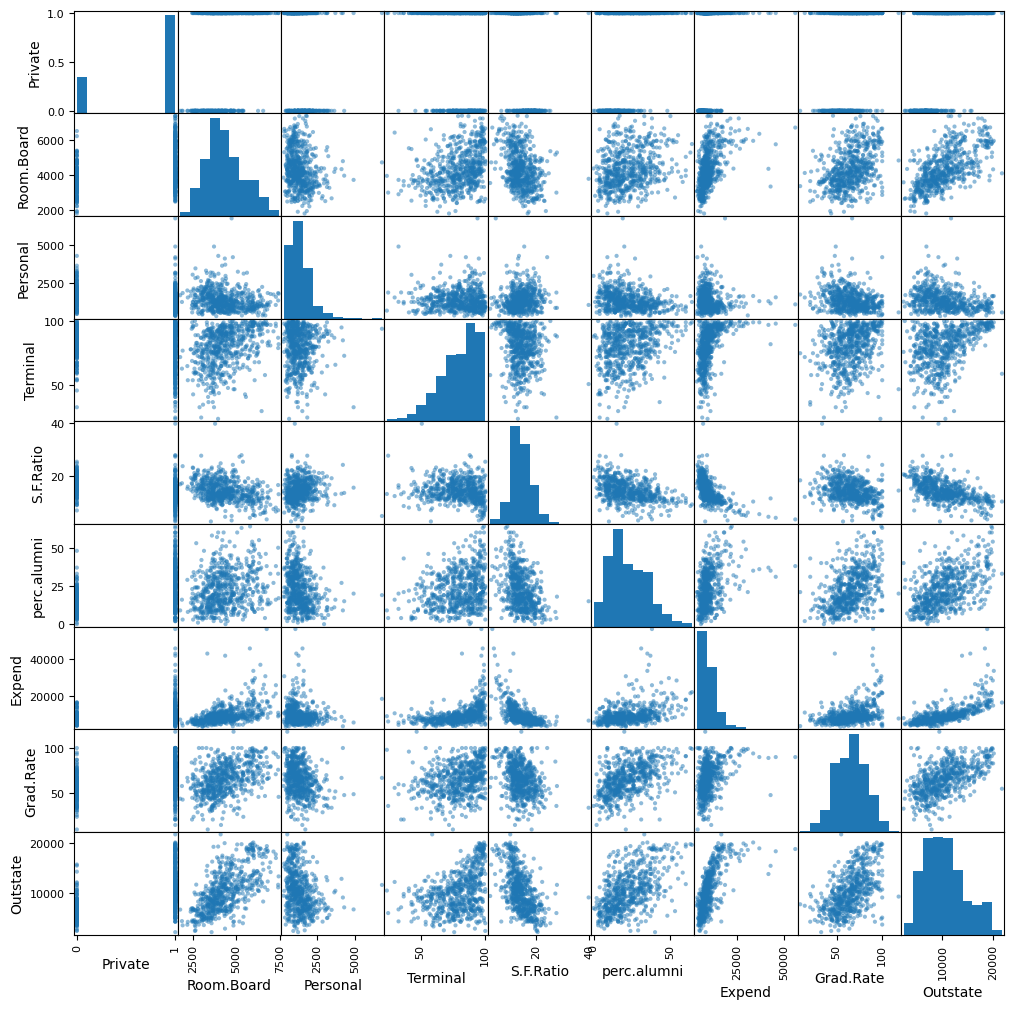

In [107]:
X_train_masked = X_train.iloc[:, model_selection.support_]
X_test_masked = X_test.iloc[:, model_selection.support_]
fig = pd.plotting.scatter_matrix(pd.concat([X_train_masked, y], axis='columns'), figsize=(12, 12))

We see some non-linearities when it comes to the relationship between outstate and some other variables.

In [108]:
gam = LinearGAM(f_gam(0, lam=0.6) + s_gam(1, lam=0.6) + s_gam(2, lam=0.6) + s_gam(3, lam=0.6) +
                s_gam(4, lam=0.6) + s_gam(5, lam=0.6) + s_gam(6, lam=0.6) + s_gam(7, lam=0.6))
gam.fit(X_train_masked, Y_train)
gam = gam.gridsearch(X_train_masked, Y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


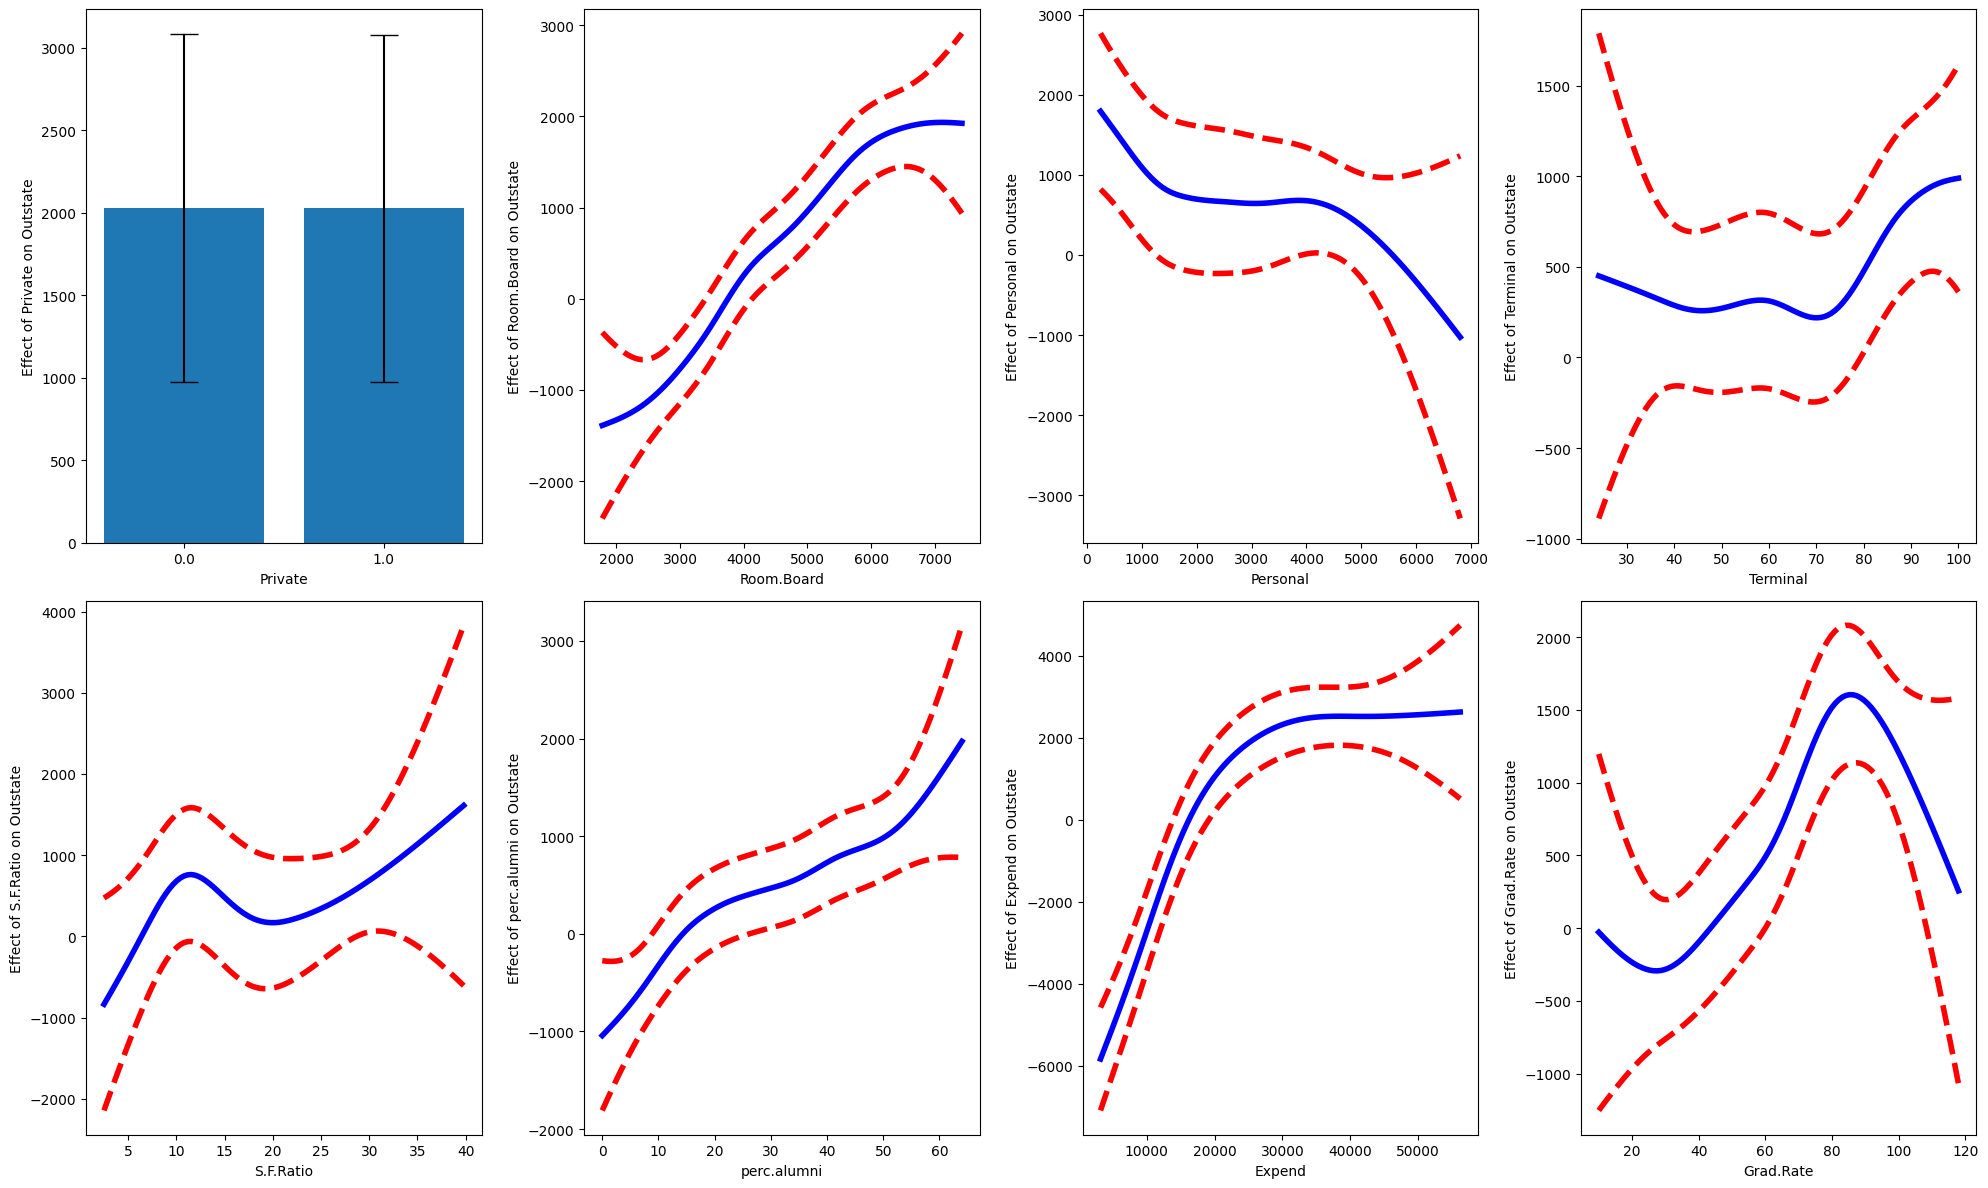

In [109]:
fig = plt.figure(figsize=(20, 12))
for i, feature in enumerate(X_train_masked.columns):
    ax = fig.add_subplot(2, 4, i+1)
    plot_gam(gam, i, ax=ax)
    ax.set_ylabel(f'Effect of {feature} on Outstate')
    ax.set_xlabel(feature)
fig.tight_layout()

In [110]:
Train_MSE = np.mean(np.power(Y_train - gam.predict(X_train_masked), 2))
Train_MSE

3487135.1426379737

(c) Evaluate the model obtained on the test set, and explain the results obtained.

In [111]:
Test_MSE = np.mean(np.power(Y_test - gam.predict(X_test_masked), 2))
Test_MSE

2848489.9274012186

(d) For which variables, if any, is there evidence of non-linear relationship with the response?

In [112]:
anova_gam(gam)

deviance          df  deviance_diff  df_diff   F  pvalue
0  2.165511e+09  591.847094            NaN      NaN NaN     NaN

In [113]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     29.1529
Link Function:                     IdentityLink Log Likelihood:                                 -9955.6313
Number of Samples:                          621 AIC:                                            19971.5684
                                                AICc:                                           19974.7535
                                                GCV:                                          3995007.4232
                                                Scale:                                        3658902.6864
                                                Pseudo R-Squared:                                   0.7848
Feature Function                  Lam

/tmp/ipykernel_17599/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [114]:
X_train_spline = pd.concat([BSpline(df=4, degree=3)
           .fit_transform(X_train_masked[feature])
           .add_prefix(feature + '_', axis='columns')
           for feature in X_train_masked.columns], axis='columns')
sm.OLS(Y_train, X_train_spline).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Outstate   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              648.7
Date:                Sat, 16 Sep 2023   Prob (F-statistic):                        0.00
Time:                        10:06:18   Log-Likelihood:                         -5599.1
No. Observations:                 621   AIC:                                  1.125e+04
Df Residuals:                     593   BIC:                                  1.138e+04
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Private_BSpline(df=4, lower_bound=0.0, upper_bound=1.0)[0]          -3.337e-13    6.6e-13     -0.506      0.613   -1.63e-12    9.62e-13
Private_BSpline(df=4, lower_bound=0.0, upper_bound=1.0)[1]           5.107e-12   1.08e-12      4.729      0.000    2.99e-12    7.23e-12
Private_BSpline(df=4, lower_bound=0.0, upper_bound=1.0)[2]          -3.795e-12   1.57e-12     -2.420      0.016   -6.87e-12   -7.16e-13
Private_BSpline(df=4, lower_bound=0.0, upper_bound=1.0)[3]           1.091e-12    1.1e-12      0.995      0.320   -1.06e-12    3.24e-12
Room.Board_BSpline(df=4, lower_bound=1780.0, upper_bound=7425.0)[0]  1274.8286   1341.312      0.950      0.342   -1359.472    3909.129
Room.Board_BSpline(df=4, lower_bound=1780.0, upper_bound=7425.0)[1]  3245.0407    947.327      3.425      0.001    1384.517    5105.564
Room.Board_BSpline(df=4, lower_bound=1780.0, upper_bound=7425.0)[2]  4908.9572   1326.653      3.700      0.000    2303.446    7514.468
Room.Board_BSpline(df=4, lower_bound=1780.0, upper_bound=7425.0)[3]  4546.0337   1187.768      3.827      0.000    2213.289    6878.778
Personal_BSpline(df=4, lower_bound=250.0, upper_bound=6800.0)[0]      237.6666    816.398      0.291      0.771   -1365.717    1841.050
Personal_BSpline(df=4, lower_bound=250.0, upper_bound=6800.0)[1]    -3038.9341    907.472     -3.349      0.001   -4821.183   -1256.685
Personal_BSpline(df=4, lower_bound=250.0, upper_bound=6800.0)[2]     1458.7178   2251.148      0.648      0.517   -2962.475    5879.910
Personal_BSpline(df=4, lower_bound=250.0, upper_bound=6800.0)[3]    -2512.3385   2098.123     -1.197      0.232   -6632.994    1608.317
Terminal_BSpline(df=4, lower_bound=24.0, upper_bound=100.0)[0]       1513.5287   1723.161      0.878      0.380   -1870.711    4897.768
Terminal_BSpline(df=4, lower_bound=24.0, upper_bound=100.0)[1]       -652.9432   1041.766     -0.627      0.531   -2698.944    1393.057
Terminal_BSpline(df=4, lower_bound=24.0, upper_bound=100.0)[2]        626.5980   1171.059      0.535      0.593   -1673.330    2926.526
Terminal_BSpline(df=4, lower_bound=24.0, upper_bound=100.0)[3]        213.7586   1091.344      0.196      0.845   -1929.610    2357.127
S.F.Ratio_BSpline(df=4, lower_bound=2.5, upper_bound=39.8)[0]        4205.3433   1389.645      3.026      0.003    1476.119    6934.568
S.F.Ratio_BSpline(df=4, lower_bound=2.5, upper_bound=39.8)[1]        3028.3699   1405.894      2.154      0.032     267.233    5789.507
S.F.Ratio_BSpline(df=4, lower_bound=2.5, upper_bound=39.8)[2]         942.2929   2091.316      0.451      0.652   -3164.995    5

In [115]:
for feature in X.columns:
    linear = LinearGAM(l_gam(0)).fit(X[feature], y)
    non_linear = LinearGAM(s_gam(0)).fit(X[feature], y)
    print(feature)
    print(anova_gam(linear, non_linear))
    print('-----')

Private
       deviance          df  deviance_diff   df_diff        F    pvalue
0  8.723470e+09  775.003877            NaN       NaN      NaN       NaN
1  8.723413e+09  775.000000   57659.032389  0.003877  1.32124  0.011506
-----
Apps
       deviance          df  deviance_diff   df_diff         F    pvalue
0  1.252770e+10  775.000000            NaN       NaN       NaN       NaN
1  1.212591e+10  769.538142   4.017939e+08  5.461858  4.668517  0.029372
-----
Accept
       deviance          df  deviance_diff   df_diff         F    pvalue
0  1.255097e+10  775.000000            NaN       NaN       NaN       NaN
1  1.195706e+10  767.894687   5.939053e+08  7.105313  5.367983  0.011142
-----
Enroll
       deviance          df  deviance_diff   df_diff         F    pvalue
0  1.225570e+10  775.000000            NaN       NaN       NaN       NaN
1  1.164297e+10  765.915906   6.127295e+08  9.084094  4.437154  0.011455
-----
Top10perc
       deviance          df  deviance_diff    df_diff         F   

The p-values that are low enough represent that the relationship is probably non-linear.

11. In section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. The idea behind backfitting is actually quite simple. We will now explore the backfitting in the context of multiple linear regression.

    Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient estimate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued until convergence, that is, until that coefficient estimated stop changing. We not try this out on a toy example.

(a) Generate a response Y and two predicotrs X1 and X2 with n = 100.

In [116]:
np.random.seed(1)
x1 = np.random.randn(100)
x2 = np.random.randn(100)
y = np.random.randn(100)

(b) Write a function simple_reg() that takes two arguments outcome and feature, fits a simple linear regression model with this outcome and feature, and returns the estimated intercept and slope.

In [117]:
def simple_reg(outcome, feature):
    model = sm.OLS(outcome, sm.add_constant(feature)).fit()
    return model.params

(c) Initialize beta1 to take on a value of your choice. It does not matter what value you choose

In [118]:
beta1 = 3.27

(d) Keeping beta1 fixed, use your function simple_reg() to fit the model:

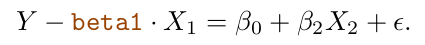

Store the resulting values as beta0 and beta2.

In [119]:
beta0, beta2 = simple_reg(
    outcome=y-beta1*x1,
    feature=x2)

(e) Keeping beta2 fixed, fit the model

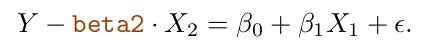

Store the results as beta0 and beta1 (overwriting their previous values).

In [120]:
beta0, beta1 = simple_reg(
    outcome=y-beta2*x2,
    feature=x1)

(f) Write a for loop to repeat (c) and (d) 1000 times. Report the estimates of beta0, beta1 and beta2 at each iteration of the for loop. Create a plot in which each of these values is displayed, with beta0, beta1 and beta2.

In [121]:
beta0s = []
beta1s = []
beta2s = []
beta1 = 3.27
for _ in range(15):
    beta0, beta2 = simple_reg(
        outcome=y-beta1*x1,
        feature=x2)
    beta0, beta1 = simple_reg(
        outcome=y-beta2*x2,
        feature=x1)
    beta0s.append(beta0)
    beta1s.append(beta1)
    beta2s.append(beta2)

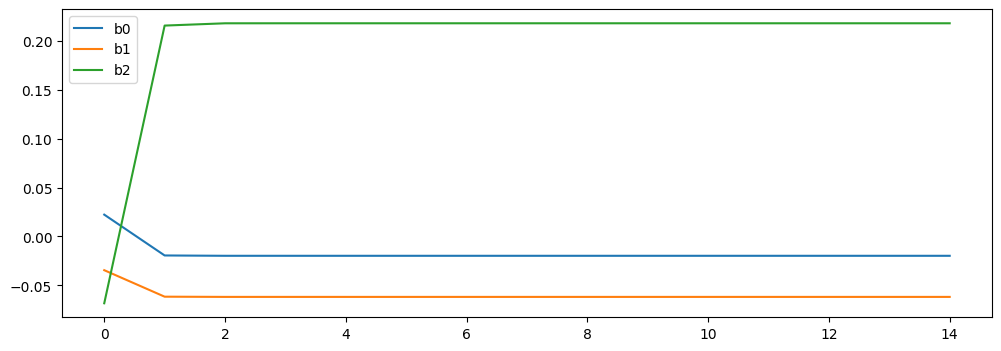

In [122]:
fig = plt.figure(figsize=(12,4)); ax = fig.add_subplot()
ax.plot(np.arange(0, len(beta0s)), beta0s, label='b0')
ax.plot(np.arange(0, len(beta0s)), beta1s, label='b1')
ax.plot(np.arange(0, len(beta0s)), beta2s, label='b2')
ax.legend()

(g) Compare your answer in (f) to the results of simply performing multiple linear regression to predict Y using X1 and X2. Use axline() method to overlay those multiple linear regression coefficient estimates on the plot obtained in (f). (changed e to f, I think its an error in writing the exercise)

In [123]:
beta0, beta1, beta2 = simple_reg(y, np.stack([x1, x2], axis=1))

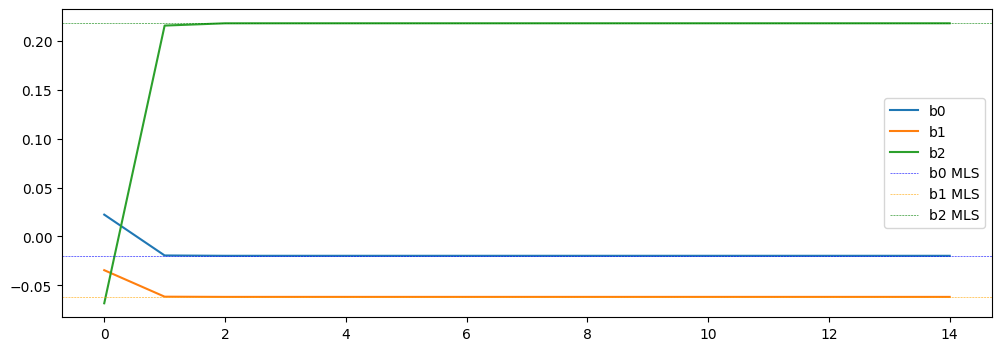

In [124]:
ax.axhline(beta0, ls='--', c='b', linewidth=0.4, label='b0 MLS')
ax.axhline(beta1, ls='--', c='orange', linewidth=0.4, label='b1 MLS')
ax.axhline(beta2, ls='--', c='green', linewidth=0.4, label='b2 MLS')
ax.legend()
fig

(h) On this data set, how many backfitting iterations were required in order to obtain a good approximation to the multiple regression coefficient estimates?

In [125]:
beta1s

[-0.0345289183082243,
 -0.06167243821014883,
 -0.06189539606310755,
 -0.061897227446965505,
 -0.06189724249001868,
 -0.06189724261358287,
 -0.06189724261459784,
 -0.061897242614606156,
 -0.061897242614606274,
 -0.061897242614606274,
 -0.061897242614606274,
 -0.061897242614606274,
 -0.061897242614606274,
 -0.061897242614606274,
 -0.061897242614606274]

In [347]:
beta0s = []
beta1s = []
beta2s = []
beta1 = 3.27
for _ in range(15):
    beta0, beta2 = simple_reg(
        outcome=y-beta1*x1,
        feature=x2)
    beta0, beta1 = simple_reg(
        outcome=y-beta2*x2,
        feature=x1)
    beta0s.append(beta0)
    beta1s.append(beta1)
    beta2s.append(beta2)

From the 8th iteration we seem to approximate multiple linear regression coefficients well.

12. This problem is a continuation of the previous exercise. In a toy example with p=100, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting proceduse. How many backfitting iterations are required in order to obtain a good approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [702]:
np.random.seed(10)
x = np.random.randn(10000, 100)
y = np.random.randn(10000)
betas = np.random.randn(x.shape[1]+1) # also including the intercept

In [703]:
def _compute_outcome(y, beta, x):
    return y-beta*x

def _perform_an_iteration(x, y, beta):
    for i in range(1, x.shape[1]):
        # Creating a mask for the current i
        mask = np.ones(len(beta), dtype=bool)
        mask[[i]] = False
        # Updating the beta values using linear regression
        beta[mask] = simple_reg(
                            outcome=_compute_outcome(y, beta[i], x[:, i-1]),
                            feature=np.delete(x, i-1, axis=1))
    return beta

def perform_backfitting(n, x, y, beta):
    beta = beta.copy()
    beta_steps = np.ones((beta.shape[0], n))
    for i in range(n):
        beta = _perform_an_iteration(x, y, beta)
        beta_steps[:, i] = beta
    return beta_steps

In [704]:
beta_steps = perform_backfitting(25, x, y, betas)
beta_mls = simple_reg(y, x)

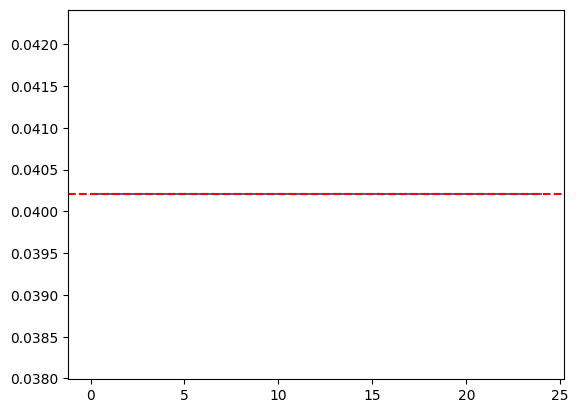

In [694]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(25),
        beta_steps[0])
ax.axhline(beta_mls[0], c='r', ls='--')

In [840]:
def _generate_data(n, p):
    np.random.seed(0)
    x = np.random.randn(n, p)
    y = np.random.randn(n)
    betas = np.random.randn(x.shape[1]+1) # also including the intercept
    return x, y, betas

def _compute_outcome(y, beta, x):
    return y-beta*x

def _perform_an_iteration(x, y, beta, i):
    # Creating a mask for the current i
    mask = np.ones(len(beta), dtype=bool)
    mask[[i+1]] = False
    # Updating the beta values using linear regression
    beta[mask] = _simple_reg(
                        outcome=_compute_outcome(y, beta[i+1], x[:, i]),
                        feature=np.delete(x, i, axis=1))
    return beta

def _plot_backfit(x, y, beta_steps, i):
    beta_mls = _simple_reg(y, x)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    for coef_backfit, coef_mls in zip(beta_steps[:i],
                                      beta_mls[:i]):
        ax.plot(np.arange(beta_steps.shape[1]),
                coef_backfit)
        ax.axhline(coef_mls, ls='--',
                   c=fig.gca().lines[-1].get_color(),
                   linewidth=0.4)
    ax.set_xlabel('number of iterations')
    ax.set_ylabel('coefficient values')

def _simple_reg(outcome, feature):
    model = sm.OLS(outcome, sm.add_constant(feature)).fit()
    return model.params

def perform_backfitting(n, p, n_iter, plot_i=None):
    x, y, beta = _generate_data(n, p)
    beta = beta.copy()
    beta_steps = np.ones((beta.shape[0], n_iter))
    for i in range(n_iter):
        beta = _perform_an_iteration(x, y, beta, i % p)
        beta_steps[:, i] = beta

    if plot_i == None: plot_i = p+1
    _plot_backfit(x, y, beta_steps, plot_i)
    return beta_steps

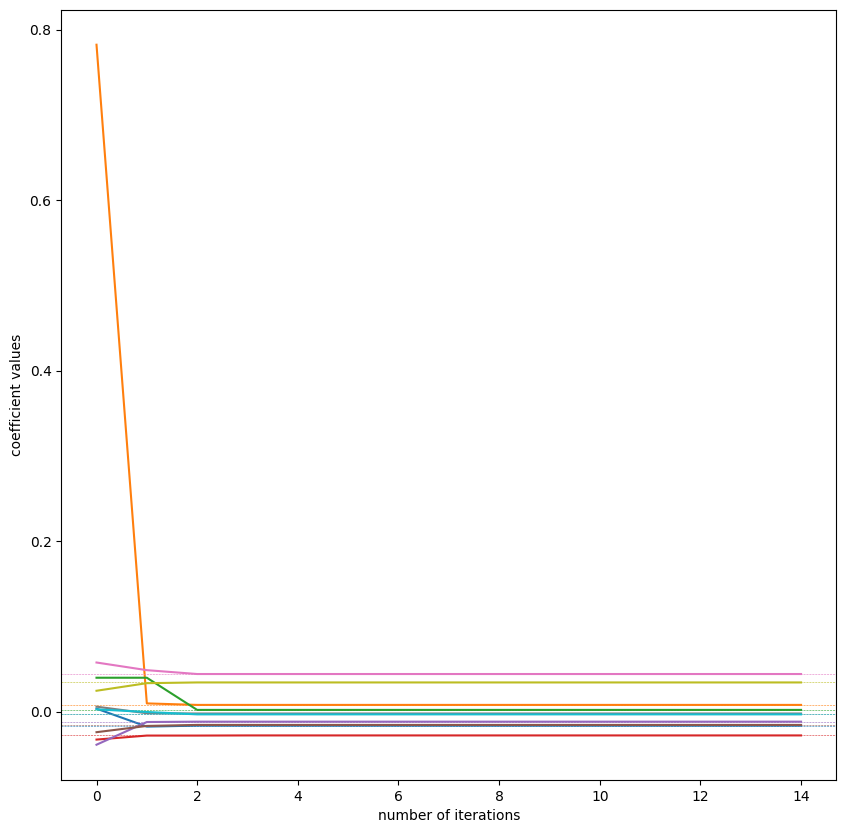

In [841]:
beta_steps = perform_backfitting(n=1000, p=50, n_iter=15, plot_i=10)